In [1]:
from flumodelingsuite.config_loader import load_model_config_from_file, setup_epimodel_from_config
from flumodelingsuite.vaccinations import get_age_group_mapping, smh_data_to_epydemix, make_vaccination_probability_function, add_vaccination_schedule ,reaggregate_vaccines
from flumodelingsuite.school_closures import make_school_closure_dict, add_school_closure_interventions
from flumodelingsuite.seasonality import get_seasonal_transmission_balcan
from flumodelingsuite.utils import convert_location_name_format
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from epydemix.population import load_epydemix_population
from epydemix.utils import convert_to_2Darray
from epydemix.model import EpiModel
from epydemix.calibration import ABCSampler, rmse 
from epydemix.visualization import plot_distance_distribution, plot_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
from epydemix import simulate
import copy  
from scipy import stats 

In [3]:
from flumodelingsuite.calibration import calc_beta, make_simulate_wrapper, calibrate

In [4]:
hosp_data = pd.read_csv("data/influenza_hosp_24.csv")
exclude = ['as', 'gu', 'mp', 'pr', 'vi']
hosp_data = hosp_data.query("geo_value not in @exclude")
hosp_data['geo_value'] = [convert_location_name_format(loc.upper(), 'ISO') for loc in hosp_data['geo_value']]
hosp_data['as_of'] = pd.to_datetime(hosp_data['as_of'])
hosp_data['issue'] = pd.to_datetime(hosp_data['issue'])
hosp_data["target_end_date"] = pd.to_datetime(hosp_data["target_end_date"])

# plt.plot(hosp_data_ma.target_end_date, hosp_data_ma.value, marker='o', linestyle='-', color='blue')

In [5]:
def add_population(state_name, model, target_age_groups=["0-4", "5-17", "18-49", "50-64", "65+"]):
    state_population_name = convert_location_name_format(state_name, "epydemix_population")
    population = load_epydemix_population(state_population_name, age_group_mapping=get_age_group_mapping(target_age_groups))
    model2 = copy.deepcopy(model) 
    model2.set_population(population)
    return model2

In [6]:
def add_school_closures(model, years, reduction=0.344):
    closure_dict = make_school_closure_dict(years)
    model2 = copy.deepcopy(model)
    add_school_closure_interventions(model2, closure_dict, reduction)
    return model2

In [7]:
def create_flu_model(parameter_dict):
    """ 
    """
    model_compartments = ["Susceptible","Susceptible_vax","Latent","Latent_vax","Infectious_symptomatic","Infectious_symptomatic_vax","Infectious_asymptomatic",
    "Infectious_asymptomatic_vax","Home_severe","Home_severe_vax","Home_mild","Home_mild_vax","Home_asymptomatic","Home_asymptomatic_vax","Hospitalized",
    "Hospitalized_vax","Removed_severe","Removed_severe_vax","Removed_mild","Removed_mild_vax","Removed_asymptomatic","Removed_asymptomatic_vax"]

    model = EpiModel(compartments=model_compartments)

    parameter_dict = parameter_dict

    # Set model parameters
    model.add_parameter(
        parameters_dict=parameter_dict)

    # Add compartment transitions
    #Infections
    model.add_transition(source="Susceptible", target="Latent", params=("beta", "Infectious_symptomatic"), kind="mediated")
    model.add_transition(source="Susceptible", target="Latent", params=("beta*r_beta_asymp", "Infectious_asymptomatic"), kind="mediated")

    model.add_transition(source="Susceptible", target="Latent", params=("beta", "Infectious_symptomatic_vax"), kind="mediated")
    model.add_transition(source="Susceptible", target="Latent", params=("beta*r_beta_asymp", "Infectious_asymptomatic_vax"), kind="mediated")
    #Transitions
    #L->I
    model.add_transition(source="Latent", target="Infectious_symptomatic", params="eps*(1-p_asymptomatic)", kind="spontaneous")  
    model.add_transition(source="Latent", target="Infectious_asymptomatic", params="eps*p_asymptomatic", kind="spontaneous")  

    #I->Home
    model.add_transition(source="Infectious_symptomatic", target="Home_severe", params="mu*p_h", kind="spontaneous")  
    model.add_transition(source="Infectious_symptomatic", target="Home_mild", params="mu*(1-p_h)", kind="spontaneous")  
    model.add_transition(source="Infectious_asymptomatic", target="Home_asymptomatic", params="mu", kind="spontaneous") 

    # Home --> Others
    model.add_transition(source="Home_severe", target="Hospitalized", params="delta", kind="spontaneous") 
    model.add_transition(source="Home_mild", target="Removed_mild", params="eta", kind="spontaneous")  
    model.add_transition(source="Home_asymptomatic", target="Removed_asymptomatic", params="eta", kind="spontaneous")  

    model.add_transition(source="Hospitalized", target="Removed_severe", params="mu_h", kind="spontaneous")

    #Build in the vaccination transitions and the vaccination branch here
    #Infections
    model.add_transition(source="Susceptible_vax", target="Latent_vax", params=("beta*r_beta_vax", "Infectious_symptomatic_vax"), kind="mediated")
    model.add_transition(source="Susceptible_vax", target="Latent_vax", params=("beta*r_beta_asymp*r_vax", "Infectious_asymptomatic_vax"), kind="mediated")

    model.add_transition(source="Susceptible_vax", target="Latent_vax", params=("beta*r_beta_vax", "Infectious_symptomatic"), kind="mediated")
    model.add_transition(source="Susceptible_vax", target="Latent_vax", params=("beta*r_beta_asymp*r_vax", "Infectious_asymptomatic"), kind="mediated")

    #Transitions
    #L->I
    model.add_transition(source="Latent_vax", target="Infectious_symptomatic_vax", params="eps*(1-p_asymptomatic)", kind="spontaneous")  
    model.add_transition(source="Latent_vax", target="Infectious_asymptomatic_vax", params="eps*p_asymptomatic", kind="spontaneous")  

    #I->Home
    model.add_transition(source="Infectious_symptomatic_vax", target="Home_severe_vax", params="mu*p_h", kind="spontaneous")  
    model.add_transition(source="Infectious_symptomatic_vax", target="Home_mild_vax", params="mu*(1-p_h)", kind="spontaneous")  
    model.add_transition(source="Infectious_asymptomatic_vax", target="Home_asymptomatic_vax", params="mu", kind="spontaneous") 

    # Home --> Others
    model.add_transition(source="Home_severe_vax", target="Hospitalized_vax", params="delta", kind="spontaneous") 
    model.add_transition(source="Home_mild_vax", target="Removed_mild_vax", params="eta", kind="spontaneous")  
    model.add_transition(source="Home_asymptomatic_vax", target="Removed_asymptomatic_vax", params="eta", kind="spontaneous")  

    model.add_transition(source="Hospitalized_vax", target="Removed_severe_vax", params="mu_h", kind="spontaneous")
    ###

    return model




In [688]:
def calc_beta(
    model_pop, 
    R0=1.2, 
    mu=1/1.5, 
    p_asymptomatic=0.45, 
    rbeta_asymp=0.5, 
):
    C = np.sum([c for _, c in model_pop.contact_matrices.items()], axis=0)
    eigenvalue = np.linalg.eigvals(C).real.max()

    return R0*mu/(eigenvalue*(1-p_asymptomatic+p_asymptomatic*rbeta_asymp))

population = load_epydemix_population("United_States_Massachusetts", age_group_mapping={
    "0-4": [str(i) for i in range(0, 5)],
    "5-17": [str(i) for i in range(5, 18)],
    "18-49": [str(i) for i in range(18, 50)],
    "50-64": [str(i) for i in range(50, 65)],
    "65+": [str(i) for i in range(65, 84)] + ["84+"]
})
calc_beta(population, R0 = 1.1)

np.float64(0.06677909958070835)

In [8]:
date_start = dt.date(2024, 10, 1)
date_stop = dt.date(2025, 5, 30)
val_min = 0.7
val_max = 1.0
dates, st = get_seasonal_transmission_balcan(
        date_start=date_start,
        date_stop=date_stop,
        date_tmax=dt.date(2025, 1, 1), # peak transmission is January 1
        date_tmin=dt.date(2025, 7, 1), # lowest transmission is July 1
        val_min=val_min,
        val_max=val_max
    )


In [9]:
parameter_dict = {
    "r_beta_asymp": 0.5,\
    "r_beta_vax": 0.7,\
    "r_vax":0.5,\
    "p_asymptomatic": 0.45,\
    "eps": 1/1.5,\
    "mu": 1/1.5,\
    "p_h": convert_to_2Darray([0.007,0.0027,0.0056,0.0110,0.0909]),\
    "mu_h":convert_to_2Darray([1/2.7, 1/3.6, 1/5.8,1/7.5,1/5.1]),\
    "delta":convert_to_2Darray([1/1.26,1/1.21,1/1.91,1/2.03,1/1.5]),\
    "eta": 1/3.5,
    }

model = create_flu_model(parameter_dict)
model = add_population("Massachusetts", model)
model = add_school_closures(model, [2024, 2025])

Calculating closures from school calendars...

Merging school closures for total US model...

Finished iteration = 1. Progress to next iteration... 

Data reduction succesful! Stopped at iteration 2

Adding state and national holidays...

School closures computed.

School closure interventions added to model for United_States_Massachusetts



In [10]:
reference_date, stop_date = dt.date(2024, 9, 13), dt.date(2025,5,30)
all_scen = smh_data_to_epydemix(
    input_filepath = 'data/vaccine_scenarios_2425.csv', 
    start_date=reference_date, 
    end_date=stop_date,
    target_age_groups=["0-4", "5-17", "18-49", "50-64", "65+"]
)

In [11]:
def make_model_list(state_list, parameter_dict):
    model_list = []
    for state in state_list:
        model = create_flu_model(parameter_dict)
        model = add_population(state, model)
        model = add_school_closures(model, [2024, 2025])
        model_list.append(model)
    return model_list

In [12]:
st_list = ['US-MA', 'US-NY', 'US-CA']
mdl_list = make_model_list(st_list, parameter_dict)

Calculating closures from school calendars...

Merging school closures for total US model...

Finished iteration = 1. Progress to next iteration... 

Data reduction succesful! Stopped at iteration 2

Adding state and national holidays...

School closures computed.

School closure interventions added to model for United_States_Massachusetts

Calculating closures from school calendars...

Merging school closures for total US model...

Finished iteration = 1. Progress to next iteration... 

Data reduction succesful! Stopped at iteration 2

Adding state and national holidays...

School closures computed.

School closure interventions added to model for United_States_New_York

Calculating closures from school calendars...

Merging school closures for total US model...

Finished iteration = 1. Progress to next iteration... 

Data reduction succesful! Stopped at iteration 2

Adding state and national holidays...

School closures computed.

School closure interventions added to model for Unite

In [369]:
reference_date = dt.date(2024, 9, 13)
date_stop = dt.date(2025, 1, 30)

state_iso = 'US-MA'
vax_schedule_state = all_scen.query("location == @state_iso and scenario == 'C_D'")

model = mdl_list[0]
parameters = {
    "reference_date": reference_date,
    "end_date": date_stop,
    "resample_frequency": "W-SAT",
    "val_max": val_max,
    "val_min": val_min,
    "latent_frac": 0.0001,
}

priors = {
    'R0': stats.uniform(0.9, 1.3), 
    'start_date_offset': stats.randint(low=0, high=36) ,
    'residual_immunity': stats.uniform(0.02, 0.35),   
}


In [ ]:
def make_simulate_wrapper(model, priors, vax_sched, scenario, data):
    """
    Builds a simulate wrapper to calibrate an Epydemix model
    """
    location = model.population.name
    location_iso = convert_location_name_format(location, "ISO")
    vax_schedule_state = vax_sched.query("location == @location_iso and scenario == @scenario")

    def simulate_wrapper(params):
        # Extract the sampled parameters
        start_date_offset = 0 # defaults to 0 (no offset, just starts at reference date)
        date_stop = params['end_date']
        reference_date = params['reference_date']
        epi_model = copy.deepcopy(model) 

        if 'start_date_offset' in priors.keys():
            start_date_offset = int(params['start_date_offset'])
            actual_start_date = reference_date + dt.timedelta(days=start_date_offset)
            vax_schedule_reag = reaggregate_vaccines(
                schedule=vax_schedule_state, 
                actual_start_date=actual_start_date
            )
            vaccine_probability_function = make_vaccination_probability_function(
                origin_compartment="Susceptible", 
                eligible_compartments=["Susceptible", "Latent", "Infectious_asymptomatic", 
                                    "Home_asymptomatic", "Removed_severe", "Removed_mild", 
                                    "Removed_asymptomatic"]
            )
            epi_model = add_vaccination_schedule(
                model=epi_model,  # Use the renamed variable
                vaccine_probability_function = vaccine_probability_function,
                source_comp="Susceptible",
                target_comp="Susceptible_vax",
                vaccination_schedule = vax_schedule_reag
            )
        
        # Get the model from params and calculate beta
        if 'R0' in priors.keys(): 
            R0 = params['R0']
            beta = calc_beta(epi_model.population, R0=R0)
            _, st = get_seasonal_transmission_balcan(
                date_start=reference_date + dt.timedelta(days=start_date_offset),
                date_stop=date_stop,
                date_tmax=dt.date(2025, 1, 1), # peak transmission is January 1
                date_tmin=dt.date(2025, 7, 1), # lowest transmission is July 1
                val_min=val_min,
                val_max=val_max
            )
            beta = np.array(beta)*st
            epi_model.beta = beta

        latent_frac = params["latent_frac"]
        residual_immunity = params['residual_immunity'] if 'residual_immunity' in priors.keys() else 0.0
        init_cond = {
                "Susceptible": (1 - latent_frac - residual_immunity) * epi_model.population.Nk,
                "Latent": latent_frac * epi_model.population.Nk,  
                "Removed_severe": residual_immunity/6 * epi_model.population.Nk,
                "Removed_severe_vax": residual_immunity/6 * epi_model.population.Nk,
                "Removed_mild": residual_immunity/6 * epi_model.population.Nk,
                "Removed_mild_vax": residual_immunity/6 * epi_model.population.Nk,
                "Removed_asymptomatic": residual_immunity/6 * epi_model.population.Nk,
                "Removed_asymptomatic_vax": residual_immunity/6 * epi_model.population.Nk
        }
        sim_params = {
            'epimodel': epi_model, 
            'start_date': actual_start_date,
            'beta': beta,
            'initial_conditions_dict': init_cond,
            'end_date': date_stop,
            'resample_frequency': parameters['resample_frequency']}
        
        # Run simulation
        results = simulate(**sim_params)
        trajectory_dates = results.dates
        data_dates = list(pd.to_datetime(data['target_end_date'].values))

        mask = [date in data_dates for date in trajectory_dates]
        
        # Extract hospitalizations
        total_hosp = results.transitions["Home_severe_to_Hospitalized_total"] + \
                    results.transitions["Home_severe_vax_to_Hospitalized_vax_total"]
        
        total_hosp = total_hosp[mask]
        
        return {"data": total_hosp}
    
    return simulate_wrapper
    

In [ ]:
reference_date = dt.date(2024, 9, 13)
val_max = 1.0
val_min = 0.7
latent_frac = 0.0001
parameters = {
    "reference_date": reference_date,
    "end_date": date_stop,
    "resample_frequency": "W-SAT",
    "val_max": val_max,
    "val_min": val_min,
    "latent_frac": latent_frac,
}
priors = {
    'R0': stats.uniform(0.9, 1.3), 
    'start_date_offset': stats.randint(low=0, high=36),
    'residual_immunity': stats.uniform(0.02, 0.35),   
}

state_iso = 'US-MA'
hosp_data_state = hosp_data[hosp_data['geo_value']==state_iso]
hosp_data_state = hosp_data_state[hosp_data_state['as_of'] == '2025-01-01']
sim_wrapper = make_simulate_wrapper(mdl_list[0], priors, all_scen, 'C_D', hosp_data_state)

abc_sampler = ABCSampler(
    simulation_function=sim_wrapper, 
    priors=priors, 
    parameters=parameters, 
    observed_data=hosp_data_state["value"].values, 
    distance_function=rmse
)

In [376]:
results_abc_top = abc_sampler.calibrate(strategy="top_fraction", top_fraction = 0.05, Nsim=200)

Starting ABC top fraction selection with 200 simulations and top 5.0% selected
	Selected 10 particles (top 5.0%) with distance threshold 45.852009


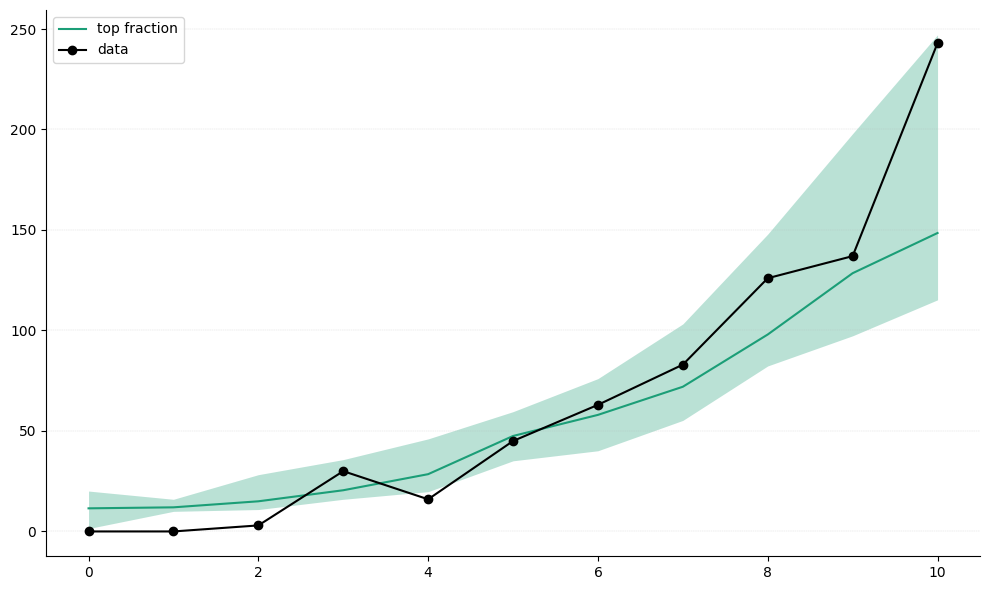

In [377]:
df_quantiles_abc_top = results_abc_top.get_calibration_quantiles()
# df_quantiles_abc_smc = results_abc_smc.get_calibration_quantiles()
hosp_data_state["data"] = hosp_data_state["value"]
fig, ax = plt.subplots(figsize=(10, 6))
plot_quantiles(df_quantiles_abc_top, columns="data", labels = ["top fraction"], ax=ax)
# plot_quantiles(df_quantiles_abc_smc, columns="data", colors=["red"], labels =["smc"], ax=ax)
plt.plot(range(0,len(hosp_data_state)), hosp_data_state['value'], marker='o', linestyle='-', color='black', label="data")
ax.legend()

In [379]:
22*100/60

36.666666666666664

<Axes: title={'center': 'Joint Distribution\nstart_date_offset vs R0'}, xlabel='start_date_offset', ylabel='R0'>

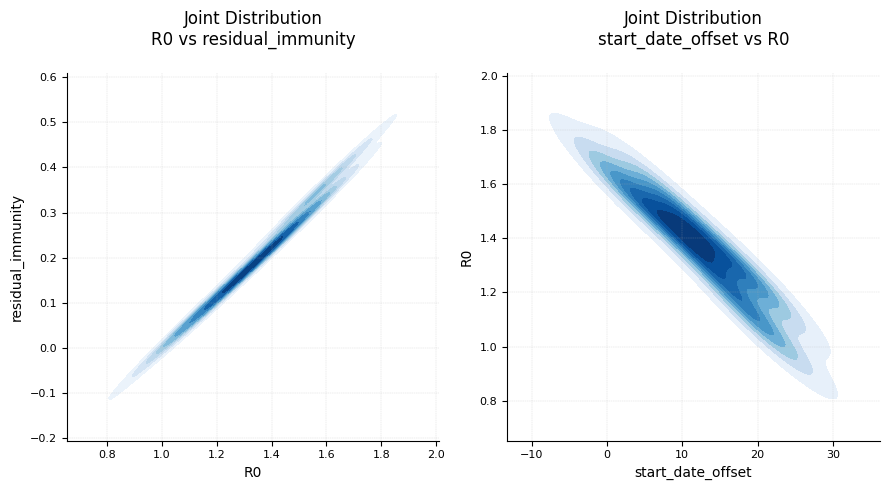

In [308]:
fig, ax = plt.subplots(1,2, figsize=(9, 5))
df_posterior_top = results_abc_top.get_posterior_distribution()
plot_posterior_distribution_2d(df_posterior_top, "R0", "residual_immunity", kind="kde", ax = ax[0])
plot_posterior_distribution_2d(df_posterior_top, "start_date_offset", "R0", kind="kde", ax = ax[1])


In [309]:
posterior = df_posterior_top.reset_index()
posterior

,index,R0,start_date_offset,residual_immunity
0,5,1.258056,19,0.142956
1,19,1.509914,9,0.281650
2,54,1.353777,12,0.196040
3,56,1.094423,20,0.057211
4,75,1.570513,3,0.348036


In [ ]:
comp_stacked = pd.DataFrame()
trans_stacked = pd.DataFrame()
model = model_list[0]
state_iso = 'US-MA'
vax_schedule_state = all_scen.query("location == @state_iso and scenario == 'C_D'")
for idx, row in posterior.iterrows():
    epimodel = copy.deepcopy(model)
    actual_start_date = reference_date + dt.timedelta(days=int(row['start_date_offset']))
    beta = calc_beta(epimodel.population, R0=row['R0'])
    _, st = get_seasonal_transmission_balcan(
        date_start=reference_date + dt.timedelta(days=int(row['start_date_offset'])),
        date_stop=date_stop,
        date_tmax=dt.date(2025, 1, 1), # peak transmission is January 1
        date_tmin=dt.date(2025, 7, 1), # lowest transmission is July 1
        val_min=val_min,
        val_max=val_max
    )
    beta = np.array(beta)*st
    epimodel.beta = beta
    vax_schedule_reag = reaggregate_vaccines(
        schedule=vax_schedule_state, 
        actual_start_date=actual_start_date
    )
    vaccine_probability_function = make_vaccination_probability_function(
        origin_compartment="Susceptible", 
        eligible_compartments=["Susceptible", "Latent", "Infectious_asymptomatic", 
                            "Home_asymptomatic", "Removed_severe", "Removed_mild", 
                            "Removed_asymptomatic"]
    )
    epimodel = add_vaccination_schedule(
        model=epimodel, 
        vaccine_probability_function = vaccine_probability_function,
        source_comp="Susceptible",
        target_comp="Susceptible_vax",
        vaccination_schedule = vax_schedule_reag
    )
    
    latent_frac = parameters["latent_frac"]
    residual_immunity = row['residual_immunity']
    init_cond = {
            "Susceptible": (1 - latent_frac - residual_immunity) * epimodel.population.Nk,
            "Latent": latent_frac * epimodel.population.Nk,  
            "Removed_severe": residual_immunity/6 * epimodel.population.Nk,
            "Removed_severe_vax": residual_immunity/6 * epimodel.population.Nk,
            "Removed_mild": residual_immunity/6 * epimodel.population.Nk,
            "Removed_mild_vax": residual_immunity/6 * epimodel.population.Nk,
            "Removed_asymptomatic": residual_immunity/6 * epimodel.population.Nk,
            "Removed_asymptomatic_vax": residual_immunity/6 * epimodel.population.Nk
    }

    sim_params = {
        'epimodel': epimodel, 
        'start_date': actual_start_date,
        'beta': beta,
        'initial_conditions_dict': init_cond,
        'end_date': parameters['end_date'],
        'resample_frequency': parameters['resample_frequency']}
    
    # Run simulation
    results = simulate(**sim_params)

    comp_results = pd.DataFrame(results.compartments)
    comp_results['idx'] = idx
    comp_results['dates'] = results.dates
    comp_stacked = pd.concat([comp_stacked, comp_results], axis=0)
    
    trans_results = pd.DataFrame(results.transitions)
    trans_results['idx'] = idx
    trans_results['dates'] = results.dates
    trans_stacked = pd.concat([trans_stacked, trans_results], axis=0)
    
trans_stacked['total_hosp'] = trans_stacked["Home_severe_to_Hospitalized_total"] + trans_stacked["Home_severe_vax_to_Hospitalized_vax_total"]

(-100.0, 1580.0)

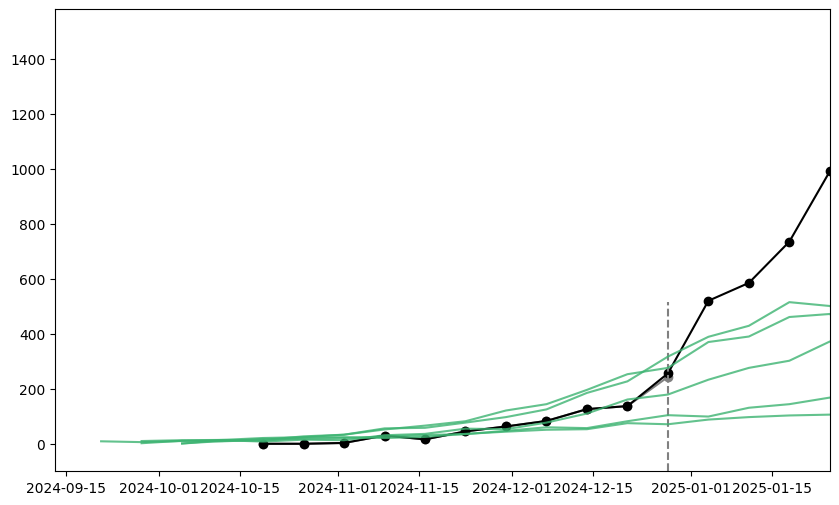

In [314]:
fig, ax = plt.subplots(figsize=(10, 6))

hosp_data_state_final = hosp_data.query("geo_value == @state_iso")
hosp_data_state_final = hosp_data_state_final[hosp_data_state_final['as_of'] == max(hosp_data_state_final['as_of'])]

ax.plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='o', linestyle='-', color='grey', label="data")
ax.plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="data")

ax.vlines(x=max(hosp_data_state.target_end_date), ymin=-100, ymax=max(trans_stacked.total_hosp), colors='gray', linestyles='dashed', label='Forecast date')
for idx in trans_stacked['idx'].unique():
    df_plot = trans_stacked.query("idx == @idx")
    ax.plot(df_plot['dates'], df_plot['total_hosp'], color='mediumseagreen', alpha=0.8)

ax.set_xlim([dt.date(2024, 9, 13), max(hosp_data_state.target_end_date)+dt.timedelta(days=4*7)])
ax.set_ylim([-100, max(hosp_data_state_final.value)])


In [ ]:
location_codebook = pd.read_csv("../flumodelingsuite/data/location_codebook.csv")

In [352]:
state_list = location_codebook['ISO'].unique().tolist()
model_list = make_model_list(state_list, parameter_dict)

Calculating closures from school calendars...

Merging school closures for total US model...

Finished iteration = 1. Progress to next iteration... 

Data reduction succesful! Stopped at iteration 2

Adding state and national holidays...

School closures computed.

School closure interventions added to model for United_States

Calculating closures from school calendars...

Merging school closures for total US model...

Finished iteration = 1. Progress to next iteration... 

Data reduction succesful! Stopped at iteration 2

Adding state and national holidays...

School closures computed.

School closure interventions added to model for United_States_Alabama

Calculating closures from school calendars...

Merging school closures for total US model...

Finished iteration = 1. Progress to next iteration... 

Data reduction succesful! Stopped at iteration 2

Adding state and national holidays...

School closures computed.

School closure interventions added to model for United_States_Alaska

In [354]:
from tqdm import tqdm

In [355]:
reference_date = dt.date(2024, 9, 13)
val_max = 1.0
val_min = 0.7
latent_frac = 0.0001
parameters = {
    "reference_date": reference_date,
    "end_date": date_stop,
    "resample_frequency": "W-SAT",
    "val_max": val_max,
    "val_min": val_min,
    "latent_frac": latent_frac,
}
priors = {
    'R0': stats.uniform(0.9, 1.3), 
    'start_date_offset': stats.randint(low=0, high=36) ,
    'residual_immunity': stats.uniform(0.02, 0.35),   
}

results_list = []
for model in tqdm(model_list):
    location = model.population.name
    location_iso = convert_location_name_format(location, "ISO")
    hosp_data_state = hosp_data[hosp_data['geo_value']==location_iso]
    hosp_data_state = hosp_data_state[hosp_data_state['as_of'] == '2025-01-01']
    sim_wrapper = make_simulate_wrapper(model, priors, all_scen, 'C_D', hosp_data_state)

    abc_sampler = ABCSampler(
        simulation_function=sim_wrapper, 
        priors=priors, 
        parameters=parameters, 
        observed_data=hosp_data_state["value"].values, 
        distance_function=rmse
    )
    results_abc_top = abc_sampler.calibrate(strategy="top_fraction", top_fraction = 0.05, Nsim=100)
    results_list.append(results_abc_top)

  0%|          | 0/52 [00:00<?, ?it/s]

Starting ABC top fraction selection with 100 simulations and top 5.0% selected


  2%|▏         | 1/52 [00:22<19:16, 22.67s/it]

	Selected 5 particles (top 5.0%) with distance threshold 3063.548947
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


  4%|▍         | 2/52 [00:43<18:04, 21.69s/it]

	Selected 5 particles (top 5.0%) with distance threshold 66.734220
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


  6%|▌         | 3/52 [01:04<17:15, 21.13s/it]

	Selected 5 particles (top 5.0%) with distance threshold 7.892134
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


  8%|▊         | 4/52 [01:25<16:56, 21.17s/it]

	Selected 5 particles (top 5.0%) with distance threshold 242.728539
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 10%|▉         | 5/52 [01:46<16:31, 21.09s/it]

	Selected 5 particles (top 5.0%) with distance threshold 21.989107
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 12%|█▏        | 6/52 [02:08<16:23, 21.38s/it]

	Selected 5 particles (top 5.0%) with distance threshold 540.950204
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 13%|█▎        | 7/52 [02:29<15:57, 21.27s/it]

	Selected 5 particles (top 5.0%) with distance threshold 97.427476
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 15%|█▌        | 8/52 [02:50<15:38, 21.32s/it]

	Selected 5 particles (top 5.0%) with distance threshold 27.108760
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 17%|█▋        | 9/52 [03:10<14:59, 20.93s/it]

	Selected 5 particles (top 5.0%) with distance threshold 19.368120
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 19%|█▉        | 10/52 [03:32<14:47, 21.13s/it]

	Selected 5 particles (top 5.0%) with distance threshold 7.895947
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 21%|██        | 11/52 [03:54<14:40, 21.49s/it]

	Selected 5 particles (top 5.0%) with distance threshold 276.909649
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 23%|██▎       | 12/52 [04:16<14:27, 21.68s/it]

	Selected 5 particles (top 5.0%) with distance threshold 134.551487
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 25%|██▌       | 13/52 [04:37<13:56, 21.44s/it]

	Selected 5 particles (top 5.0%) with distance threshold 12.502665
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 27%|██▋       | 14/52 [04:58<13:23, 21.15s/it]

	Selected 5 particles (top 5.0%) with distance threshold 54.407844
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 29%|██▉       | 15/52 [05:19<13:09, 21.35s/it]

	Selected 5 particles (top 5.0%) with distance threshold 202.004294
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 31%|███       | 16/52 [05:41<12:49, 21.38s/it]

	Selected 5 particles (top 5.0%) with distance threshold 93.672665
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 33%|███▎      | 17/52 [06:02<12:25, 21.31s/it]

	Selected 5 particles (top 5.0%) with distance threshold 23.362381
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 35%|███▍      | 18/52 [06:23<11:57, 21.10s/it]

	Selected 5 particles (top 5.0%) with distance threshold 27.329559
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 37%|███▋      | 19/52 [06:44<11:40, 21.23s/it]

	Selected 5 particles (top 5.0%) with distance threshold 76.331587
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 38%|███▊      | 20/52 [07:05<11:16, 21.16s/it]

	Selected 5 particles (top 5.0%) with distance threshold 73.470598
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 40%|████      | 21/52 [07:26<10:50, 20.99s/it]

	Selected 5 particles (top 5.0%) with distance threshold 7.303483
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 42%|████▏     | 22/52 [07:46<10:26, 20.89s/it]

	Selected 5 particles (top 5.0%) with distance threshold 22.040382
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 44%|████▍     | 23/52 [08:07<10:05, 20.88s/it]

	Selected 5 particles (top 5.0%) with distance threshold 38.248165
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 46%|████▌     | 24/52 [08:30<10:01, 21.47s/it]

	Selected 5 particles (top 5.0%) with distance threshold 71.289089
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 48%|████▊     | 25/52 [08:52<09:40, 21.48s/it]

	Selected 5 particles (top 5.0%) with distance threshold 124.619106
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 50%|█████     | 26/52 [09:12<09:10, 21.17s/it]

	Selected 5 particles (top 5.0%) with distance threshold 39.180174
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 52%|█████▏    | 27/52 [09:35<08:59, 21.58s/it]

	Selected 5 particles (top 5.0%) with distance threshold 101.006843
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 54%|█████▍    | 28/52 [09:56<08:38, 21.59s/it]

	Selected 5 particles (top 5.0%) with distance threshold 11.381070
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 56%|█████▌    | 29/52 [10:17<08:11, 21.38s/it]

	Selected 5 particles (top 5.0%) with distance threshold 29.598640
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 58%|█████▊    | 30/52 [10:38<07:48, 21.29s/it]

	Selected 5 particles (top 5.0%) with distance threshold 27.931994
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 60%|█████▉    | 31/52 [10:58<07:18, 20.87s/it]

	Selected 5 particles (top 5.0%) with distance threshold 12.994324
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 62%|██████▏   | 32/52 [11:24<07:25, 22.28s/it]

	Selected 5 particles (top 5.0%) with distance threshold 98.802001
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 63%|██████▎   | 33/52 [11:45<06:57, 21.96s/it]

	Selected 5 particles (top 5.0%) with distance threshold 30.915474
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 65%|██████▌   | 34/52 [12:07<06:33, 21.86s/it]

	Selected 5 particles (top 5.0%) with distance threshold 314.220482
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 67%|██████▋   | 35/52 [12:28<06:09, 21.73s/it]

	Selected 5 particles (top 5.0%) with distance threshold 114.038104
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 69%|██████▉   | 36/52 [12:48<05:38, 21.17s/it]

	Selected 5 particles (top 5.0%) with distance threshold 4.687980
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 71%|███████   | 37/52 [13:10<05:20, 21.37s/it]

	Selected 5 particles (top 5.0%) with distance threshold 117.225852
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 73%|███████▎  | 38/52 [13:31<04:58, 21.32s/it]

	Selected 5 particles (top 5.0%) with distance threshold 66.987509
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 75%|███████▌  | 39/52 [13:51<04:33, 21.02s/it]

	Selected 5 particles (top 5.0%) with distance threshold 93.321229
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 77%|███████▋  | 40/52 [14:16<04:25, 22.12s/it]

	Selected 5 particles (top 5.0%) with distance threshold 187.754913
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 79%|███████▉  | 41/52 [14:36<03:57, 21.56s/it]

	Selected 5 particles (top 5.0%) with distance threshold 9.142131
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 81%|████████  | 42/52 [14:57<03:34, 21.47s/it]

	Selected 5 particles (top 5.0%) with distance threshold 64.881962
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 83%|████████▎ | 43/52 [15:18<03:10, 21.12s/it]

	Selected 5 particles (top 5.0%) with distance threshold 8.316466
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 85%|████████▍ | 44/52 [15:39<02:50, 21.26s/it]

	Selected 5 particles (top 5.0%) with distance threshold 157.003753
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 87%|████████▋ | 45/52 [16:01<02:30, 21.54s/it]

	Selected 5 particles (top 5.0%) with distance threshold 211.882081
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 88%|████████▊ | 46/52 [16:22<02:07, 21.22s/it]

	Selected 5 particles (top 5.0%) with distance threshold 39.502745
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 90%|█████████ | 47/52 [16:42<01:44, 20.91s/it]

	Selected 5 particles (top 5.0%) with distance threshold 3.651862
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 92%|█████████▏| 48/52 [17:03<01:23, 20.86s/it]

	Selected 5 particles (top 5.0%) with distance threshold 80.003703
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 94%|█████████▍| 49/52 [17:24<01:03, 21.01s/it]

	Selected 5 particles (top 5.0%) with distance threshold 143.939641
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 96%|█████████▌| 50/52 [17:45<00:41, 20.89s/it]

	Selected 5 particles (top 5.0%) with distance threshold 26.483264
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


 98%|█████████▊| 51/52 [18:06<00:20, 20.98s/it]

	Selected 5 particles (top 5.0%) with distance threshold 51.606998
Starting ABC top fraction selection with 100 simulations and top 5.0% selected


100%|██████████| 52/52 [18:25<00:00, 21.26s/it]

	Selected 5 particles (top 5.0%) with distance threshold 17.590358


In [573]:
def resimulate_with_posterior(model, posterior, parameters, all_scen, scenario):
    """
    Resimulate the model with the posterior parameter sets
    """
    comp_stacked = pd.DataFrame()
    trans_stacked = pd.DataFrame()
    state_iso = convert_location_name_format(model.population.name, "ISO")
    vax_schedule_state = all_scen.query("location == @state_iso and scenario == @scenario")
    for idx, row in posterior.iterrows():
        epimodel = copy.deepcopy(model)
        actual_start_date = parameters['reference_date'] + dt.timedelta(days=int(row['start_date_offset']))
        beta = calc_beta(epimodel.population, R0=row['Rt'])
        _, st = get_seasonal_transmission_balcan(
            date_start=reference_date + dt.timedelta(days=int(row['start_date_offset'])),
            date_stop=date_stop,
            date_tmax=dt.date(2025, 1, 1), # peak transmission is January 1
            date_tmin=dt.date(2025, 7, 1), # lowest transmission is July 1
            val_min=row['val_min'],
            val_max=val_max
        )
        beta = np.array(beta)*st
        epimodel.beta = beta
        vax_schedule_state = all_scen.query("location == @state_iso and scenario == @scenario")
        vax_schedule_reag = reaggregate_vaccines(
            schedule=vax_schedule_state, 
            actual_start_date=actual_start_date
        )
        vaccine_probability_function = make_vaccination_probability_function(
            origin_compartment="Susceptible", 
            eligible_compartments=["Susceptible", "Latent", "Infectious_asymptomatic", 
                                "Home_asymptomatic", "Removed_severe", "Removed_mild", 
                                "Removed_asymptomatic"]
        )
        epimodel = add_vaccination_schedule(
            model=epimodel, 
            vaccine_probability_function = vaccine_probability_function,
            source_comp="Susceptible",
            target_comp="Susceptible_vax",
            vaccination_schedule = vax_schedule_reag
        )
        
        latent_frac = row["infectious_seed"]
        residual_immunity = row['residual_immunity']
        init_cond = {
                "Susceptible": (1 - latent_frac - residual_immunity) * epimodel.population.Nk,
                "Latent": latent_frac * epimodel.population.Nk,  
                "Removed_severe": residual_immunity/6 * epimodel.population.Nk,
                "Removed_severe_vax": residual_immunity/6 * epimodel.population.Nk,
                "Removed_mild": residual_immunity/6 * epimodel.population.Nk,
                "Removed_mild_vax": residual_immunity/6 * epimodel.population.Nk,
                "Removed_asymptomatic": residual_immunity/6 * epimodel.population.Nk,
                "Removed_asymptomatic_vax": residual_immunity/6 * epimodel.population.Nk
        }

        sim_params = {
            'epimodel': epimodel, 
            'start_date': actual_start_date,
            'beta': beta,
            'initial_conditions_dict': init_cond,
            'end_date': parameters['end_date'],
            'resample_frequency': parameters['resample_frequency']}
        
        # Run simulation
        results = simulate(**sim_params)

        comp_results = pd.DataFrame(results.compartments)
        comp_results['idx'] = idx
        comp_results['dates'] = results.dates
        comp_stacked = pd.concat([comp_stacked, comp_results], axis=0)
        
        trans_results = pd.DataFrame(results.transitions)
        trans_results['idx'] = idx
        trans_results['dates'] = results.dates
        trans_stacked = pd.concat([trans_stacked, trans_results], axis=0)

    return comp_stacked, trans_stacked

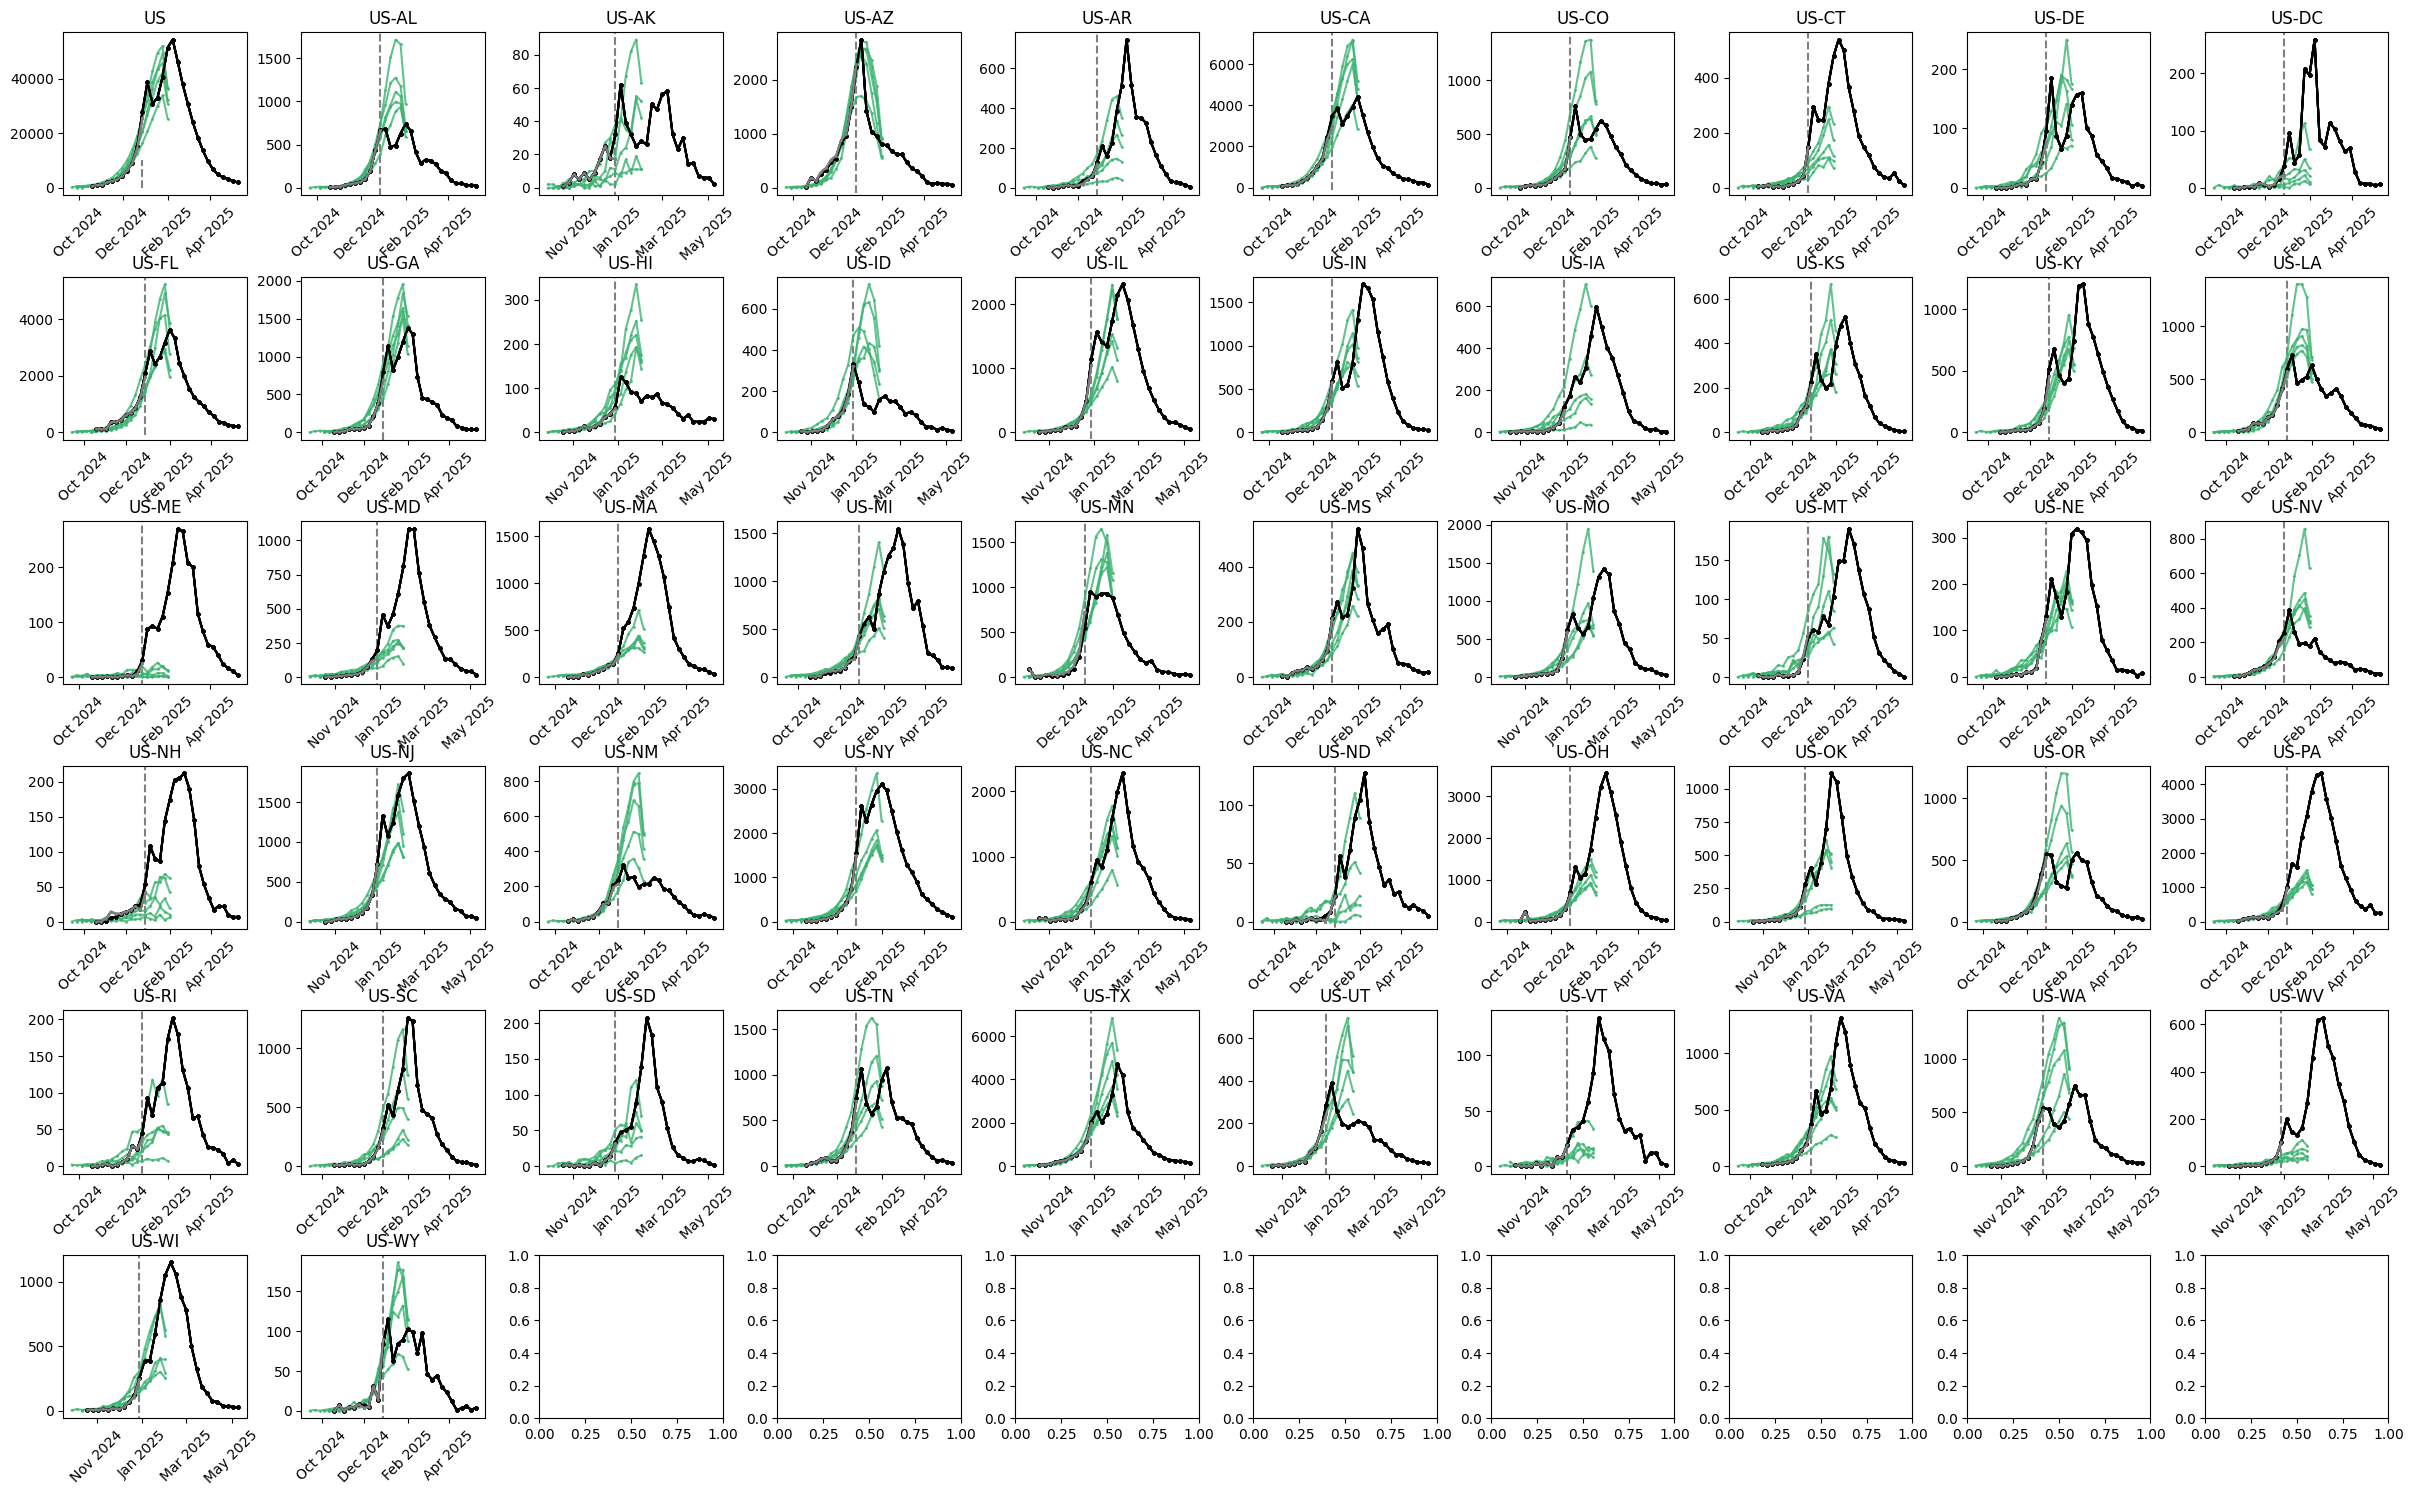

In [ ]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(6,10, figsize=(30, 18))
ax = ax.flatten()
for i, (model, results) in enumerate(zip(model_list, results_list)):
    posterior = results.get_posterior_distribution().reset_index()
    comp_stacked, trans_stacked = resimulate_with_posterior(model, posterior, parameters, all_scen, 'C_D')
    trans_stacked['total_hosp'] = trans_stacked["Home_severe_to_Hospitalized_total"] + trans_stacked["Home_severe_vax_to_Hospitalized_vax_total"]
    
    state_iso = convert_location_name_format(model.population.name, "ISO")
    hosp_data_state_final = hosp_data.query("geo_value == @state_iso")
    hosp_data_state_final = hosp_data_state_final[hosp_data_state_final['as_of'] == max(hosp_data_state_final['as_of'])]

    hosp_data_state = hosp_data[hosp_data['geo_value']==state_iso]
    hosp_data_state = hosp_data_state[hosp_data_state['as_of'] == '2025-01-01']

    ax[i].vlines(x=max(hosp_data_state.target_end_date), ymin=-100, ymax=100000, colors='gray', linestyles='dashed', label='Forecast date')
    for idx in trans_stacked['idx'].unique():
        df_plot = trans_stacked.query("idx == @idx")
        ax[i].plot(df_plot['dates'], df_plot['total_hosp'], color='mediumseagreen', alpha=0.8, marker='.', markersize=2)
        ax[i].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="data", markersize = 2)
        ax[i].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="data", markersize = 2)
    ax[i].set_title(state_list[i])
    # ax[i].set_xlim([dt.date(2024, 9, 13), max(hosp_data_state.target_end_date)+dt.timedelta(days=4*7)])
    ymin = min(0, trans_stacked['total_hosp'].min(), hosp_data_state.value.min())
    ymax = max(hosp_data_state_final.value.max(), trans_stacked['total_hosp'].max())
    # add 5% padding
    padding = 0.05 * (ymax - ymin)
    ax[i].set_ylim(ymin - padding, ymax + padding)
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))   # show one tick per 2 months
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Jan 2021"
    ax[i].tick_params(axis='x', rotation=45)  # tilt labels for readability
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    

### modelset yaml

In [410]:
from pydantic import BaseModel, Field
from typing import Any, Literal
from datetime import date

class Meta(BaseModel):
    """Metadata for the modelset."""
    description: str
    author: str
    version: str

class Distribution(BaseModel):
    """Distribution specification."""
    type: Literal["scipy", "custom"]
    name: str
    args: list[float] = Field(default_factory=list)
    kwargs: dict[str, Any] = Field(default_factory=dict)

class SamplerStrategy(BaseModel):
    """Sampler configuration."""
    strategy: Literal["grid", "LHS"]
    parameters: list[str] = Field(default_factory=list)
    n_samples: int | None = None
    compartments: list[str] | None = None

class CompartmentSampling(BaseModel):
    """Compartment sampling bounds."""
    min: float
    max: float

class ParameterSampling(BaseModel):
    """Parameter sampling specification."""
    type: Literal["date", "scalar"] | None = None
    output_type: Literal["scalar", "date"] | None = None
    reference_date: date | None = None
    distribution: Distribution | None = None
    values: list[float] | None = None

class Prior(BaseModel):
    """Prior specification for calibration."""
    type: Literal["scipy", "custom"]
    name: str
    args: list[float] = Field(default_factory=list)
    kwargs: dict[str, Any] = Field(default_factory=dict)

class CalibrationParameter(BaseModel):
    """Parameter specification for calibration."""
    output_type: Literal["scalar", "date"] = "scalar"
    reference_date: date | None = None
    prior: Prior

class Sampling(BaseModel):
    """Sampling configuration."""
    samplers: list[SamplerStrategy]
    compartments: dict[str, CompartmentSampling] | None = None
    parameters: dict[str, ParameterSampling] | None = None

class Calibration(BaseModel):
    """Calibration configuration."""
    data_path: str = Field(..., description="Path to calibration data file")
    strategy: str = Field(..., description="Calibration strategy")
    parameters: dict[str, CalibrationParameter]

class Modelset(BaseModel):
    """Main modelset configuration."""
    meta: Meta
    population_names: list[str]
    sampling: Sampling | None = None
    calibration: Calibration | None = None

class ModelsetConfig(BaseModel):
    """Root configuration for modelset."""
    modelset: Modelset

def validate_modelset_config(config: dict) -> ModelsetConfig:
    """
    Validate the given modelset configuration against the schema.
    
    Parameters
    ----------
    config: dict
        The configuration dictionary to validate.
        
    Returns
    -------
    ModelsetConfig
        The validated ModelsetConfig.
    """
    try:
        root = ModelsetConfig(**config)
        print("Modelset configuration validated successfully.")
    except Exception as e:
        raise ValueError(f"Modelset configuration validation error: {e}")
    return root

In [411]:
from pathlib import Path
import yaml
from typing import Dict, Any

def load_modelset_config_from_file(path: str) -> ModelsetConfig:
    """
    Load modelset configuration YAML from the given path and validate against the schema.
    
    Parameters
    ----------
    path : str
        The file path to the YAML configuration file.
        
    Returns
    -------
    ModelsetConfig
        The validated configuration object.
    """
    with Path(path).open() as f:
        raw = yaml.safe_load(f)
    
    root = validate_modelset_config(raw)
    print("Modelset configuration loaded successfully.")
    return root

In [446]:
modelset = load_modelset_config_from_file("../tutorials/data/modelset.yml")

Modelset configuration validated successfully.
Modelset configuration loaded successfully.


In [447]:
modelset.modelset.calibration.parameters

{'start_date': CalibrationParameter(output_type='date', reference_date=datetime.date(2024, 9, 13), prior=Prior(type='scipy', name='randint', args=[0.0, 30.0], kwargs={})),
 'Rt': CalibrationParameter(output_type='scalar', reference_date=None, prior=Prior(type='scipy', name='uniform', args=[1.0, 2.0], kwargs={})),
 'residual_immunity': CalibrationParameter(output_type='scalar', reference_date=None, prior=Prior(type='scipy', name='uniform', args=[0.02, 0.35], kwargs={})),
 'infectious_seed': CalibrationParameter(output_type='scalar', reference_date=None, prior=Prior(type='scipy', name='uniform', args=[1e-05, 0.001], kwargs={}))}

In [ ]:
import scipy.stats as stats
from datetime import date, timedelta
from typing import Dict, Any, Union

def get_priors_from_modelset(modelset_config: ModelsetConfig) -> Dict[str, Any]:
    """
    Extract priors from modelset configuration and convert them to scipy.stats distributions.
    
    Parameters
    ----------
    modelset_config : ModelsetConfig
        The validated modelset configuration object
        
    Returns
    -------
    Dict[str, Any]
        Dictionary mapping parameter names to scipy.stats distribution objects
    """
    priors = {}
    
    if modelset_config.modelset.calibration is None:
        return priors
        
    for param_name, param_config in modelset_config.modelset.calibration.parameters.items():
        prior_spec = param_config.prior
        
        # Handle date type parameters
        if param_config.output_type == "date":
            if prior_spec.name == "uniform":
                # For date parameters, args should be [low, high] representing days offset
                if len(prior_spec.args) >= 2:
                    low = int(prior_spec.args[0])
                    high = int(prior_spec.args[1])
                    # Use randint for discrete day offsets
                    priors[f"{param_name}_offset"] = stats.randint(low=low, high=high + 1)
                else:
                    raise ValueError(f"Uniform distribution for {param_name} requires 2 args [low, high]")
            else:
                # Handle other date distributions as needed
                priors[f"{param_name}_offset"] = _create_scipy_distribution(prior_spec)
                
        # Handle scalar type parameters
        elif param_config.output_type == "scalar":
            priors[param_name] = _create_scipy_distribution(prior_spec)
            
        else:
            # Default to scalar if output_type not specified
            priors[param_name] = _create_scipy_distribution(prior_spec)
    
    return priors

def _create_scipy_distribution(prior_spec) -> Any:
    """
    Create a scipy.stats distribution from a Prior specification.
    
    Parameters
    ----------
    prior_spec : Prior
        The prior specification containing type, name, args, and kwargs
        
    Returns
    -------
    Any
        A scipy.stats distribution object
    """
    if prior_spec.type == "scipy":
        # Get the distribution class from scipy.stats
        if hasattr(stats, prior_spec.name):
            dist_class = getattr(stats, prior_spec.name)
            
            # Create distribution with args and kwargs
            if prior_spec.kwargs:
                return dist_class(*prior_spec.args, **prior_spec.kwargs)
            else:
                return dist_class(*prior_spec.args)
        else:
            raise ValueError(f"Unknown scipy distribution: {prior_spec.name}")
            
    elif prior_spec.type == "custom":
        # Handle custom distributions - would need to be implemented based on your needs
        raise NotImplementedError(f"Custom distribution '{prior_spec.name}' not implemented")
        
    else:
        raise ValueError(f"Unknown prior type: {prior_spec.type}")

In [448]:
priors = get_priors_from_modelset(modelset)
priors

{'start_date_offset': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x30eb2a0f0>,
 'Rt': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x30eb29d60>,
 'residual_immunity': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x30eb2a4e0>,
 'infectious_seed': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x30eb2a600>}

In [ ]:
def make_simulate_wrapper(
    model: EpiModel,
    priors: dict,
    fixed_parameters: dict,
    data: pd.DataFrame,
    target_transitions: list[str],
    infectious_seed_compartments: list[str],
    residual_immunity_compartments: list[str],
    vaccine_probability_function,
    calc_beta,
    vax_sched: pd.DataFrame,
    scenario: str | None = None,
) -> callable:
    """
    Create a simulation wrapper function for ABC calibration of an Epydemix model.
    
    This function creates a closure that wraps the epidemic simulation with
    parameter sampling, vaccination scheduling, and output formatting suitable
    for ABC calibration methods.
    
    Parameters
    ----------
    model : EpiModel
        The epidemic model to simulate
    priors : dict
        Dictionary of prior distributions for parameters to be calibrated
    fixed_parameters : dict
        Dictionary of parameters to keep fixed during calibration
    data : pd.DataFrame
        Observed data with 'target_end_date' column for date matching
    target_transitions : list[str]
        List of transition names to sum for hospitalization output
    infectious_seed_compartments : list[str]
        Compartments to seed with initial infectious individuals
    residual_immunity_compartments : list[str]
        Compartments for individuals with residual immunity
    vaccine_probability_function : callable
        Function to calculate vaccination probabilities
    calc_beta : callable
        Function to calculate transmission rate from R0
    vax_sched : pd.DataFrame
        Vaccination schedule data with 'location' and 'scenario' columns
    scenario : str | None, default None
        Scenario name to filter vaccination schedule
        
    Returns
    -------
    callable
        Simulation wrapper function that takes parameter dict and returns
        dictionary with 'data' key containing hospitalization time series
        
    Notes
    -----
    The returned wrapper function expects parameters dict containing:
    - 'end_date': simulation end date
    - 'reference_date': simulation reference date  
    - 'infectious_seed': fraction of population initially infectious
    - 'resample_frequency': frequency for output resampling
    - 'start_date_offset': optional offset from reference date
    - 'residual_immunity': optional fraction with residual immunity
    - 'Rt': optional reproduction number for transmission calculation
    """
    location = model.population.name
    location_iso = convert_location_name_format(location, "ISO")
    vax_schedule_state = vax_sched.query("location == @location_iso")
    if scenario is not None:
        vax_schedule_state = vax_schedule_state.query("scenario == @scenario")
    
    def simulate_wrapper(params):
        # Extract the sampled parameters
        start_date_offset = 0 # defaults to 0 (no offset, just starts at reference date)
        date_stop = params['end_date']
        reference_date = params['reference_date']
        epi_model = copy.deepcopy(model) 

        if 'start_date_offset' in params.keys():
            start_date_offset = int(params['start_date_offset'])
            actual_start_date = reference_date + dt.timedelta(days=start_date_offset)
            vax_schedule_reag = reaggregate_vaccines(
                schedule=vax_schedule_state, 
                actual_start_date=actual_start_date
            )
            
            epi_model = add_vaccination_schedule(
                model=epi_model,  # Use the renamed variable
                vaccine_probability_function = vaccine_probability_function,
                source_comp="Susceptible",
                target_comp="Susceptible_vax",
                vaccination_schedule = vax_schedule_reag
            )
        
        if 'Rt' in params.keys(): 
            beta = calc_beta(epi_model.population, R0=params['Rt'])
            _, st = get_seasonal_transmission_balcan(
                date_start=reference_date + dt.timedelta(days=start_date_offset),
                date_stop=date_stop,
                date_tmax=dt.date(2025, 1, 1), # peak transmission is January 1
                date_tmin=dt.date(2025, 7, 1), # lowest transmission is July 1
                val_min=params['val_min'],
                val_max=params['val_max']
            )
            beta = np.array(beta)*st
            epi_model.beta = beta

        infectious_frac = params["infectious_seed"] # must be specified either in priors or fixed_parameters
        infectious_frac_distributed = infectious_frac / len(infectious_seed_compartments)
        residual_immunity = params['residual_immunity'] if 'residual_immunity' in params.keys() else 0.0 # must be specified either in priors or fixed_parameters
        residual_immunity_distributed = residual_immunity / len(residual_immunity_compartments)
        
        init_cond = {
            "Susceptible": (1 - infectious_frac - residual_immunity) * epi_model.population.Nk,
        }
        for comp in infectious_seed_compartments:
            init_cond[comp] = infectious_frac_distributed * epi_model.population.Nk

        for comp in residual_immunity_compartments:
            if comp not in epi_model.compartments:
                epi_model.add_compartments(comp)
                init_cond[comp] = residual_immunity_distributed * epi_model.population.Nk
        
        sim_params = {
            'epimodel': epi_model, 
            'start_date': actual_start_date,
            'beta': beta,
            'initial_conditions_dict': init_cond,
            'end_date': date_stop,
            'resample_frequency': params['resample_frequency']}
        
        # Run simulation
        try:
            results = simulate(**sim_params)
            trajectory_dates = results.dates
            data_dates = list(pd.to_datetime(data['target_end_date'].values))

            mask = [date in data_dates for date in trajectory_dates]
            
            total_hosp = sum(results.transitions[key] for key in target_transitions)
            
            total_hosp = total_hosp[mask]

        except Exception as e:
            print(f"Simulation failed with parameters {params}: {e}")
            data_dates = list(pd.to_datetime(data['target_end_date'].values))
            total_hosp = np.full(len(data_dates), 0)
        return {"data": total_hosp}
    
    return simulate_wrapper
    

In [461]:
from flumodelingsuite.config_loader import load_model_config_from_file, setup_epimodel_from_config
config = load_model_config_from_file('../tutorials/data/input.yml')
# model_config = setup_epimodel_from_config(config)

In [452]:
modelset.modelset.calibration.parameters['start_date'].reference_date

datetime.date(2024, 9, 13)

In [467]:
config.model.simulation.end_date

datetime.date(2025, 5, 30)

In [ ]:
config.model.simulation.start_date

datetime.date(2024, 9, 13)

In [ ]:
def parameters_constructor(config, modelset):
    try: 
        ref_date = modelset.modelset.calibration.parameters['start_date'].reference_date
    except:
        ref_date = config.model.simulation.start_date

    try: 
        resample_freq = config.model.simulation.resample_frequency 
    except:
        ref_date = config.model.simulation.start_date

    parameters = {
        "reference_date": ref_date,
        "end_date": config.model.simulation.end_date,
        "resample_frequency": config.model.simulation.resample_frequency,
        "val_max": config.model.simulation.val_max,
        "val_min": config.model.simulation.val_min,
        "infectious_seed": config.model.simulation.infectious_seed,
    }
    return parameters

In [17]:
parameter_dict

{'r_beta_asymp': 0.5,
 'r_beta_vax': 0.7,
 'r_vax': 0.5,
 'p_asymptomatic': 0.45,
 'eps': 0.6666666666666666,
 'mu': 0.6666666666666666,
 'p_h': array([[0.007 , 0.0027, 0.0056, 0.011 , 0.0909]]),
 'mu_h': array([[0.37037037, 0.27777778, 0.17241379, 0.13333333, 0.19607843]]),
 'delta': array([[0.79365079, 0.82644628, 0.52356021, 0.49261084, 0.66666667]]),
 'eta': 0.2857142857142857}

In [ ]:
# reference_date = modelset.modelset.calibration.parameters['start_date'].reference_date
# val_max = config.model.seasonality.max_value
# val_min = config.model.seasonality.min_value
# date_stop = config.model.simulation.end_date
# resample_frequency = 'W-SAT'

val_min=0.5
val_max=1.0
fixed_parameters = {
    "reference_date": dt.date(2024, 9, 13),
    "end_date": dt.date(2025, 1, 30),
    "resample_frequency": 'W-SAT',
    "val_max": val_max,
    "val_min": val_min,
    'mu': parameter_dict['mu'],
    'p_asymptomatic': parameter_dict['p_asymptomatic'],
    'r_beta_asymptomatic': parameter_dict['r_beta_asymp'],
}
priors = {
    'Rt': stats.uniform(1.0, 1.3), 
    'start_date_offset': stats.randint(low=0, high=36) ,
    'residual_immunity': stats.uniform(0.02, 0.35), 
    'infectious_seed': stats.uniform(0.00001, 0.00100),
}

hosp_data_state = hosp_data[hosp_data['geo_value']==state_iso]
hosp_data_state = hosp_data_state[hosp_data_state['as_of'] == '2025-01-01']

vaccine_probability_function = make_vaccination_probability_function(
        origin_compartment="Susceptible", 
        eligible_compartments=["Susceptible", "Latent", "Infectious_asymptomatic", 
                            "Home_asymptomatic", "Removed_severe", "Removed_mild", 
                            "Removed_asymptomatic"]
    )
target_transitions = ["Home_severe_to_Hospitalized_total", "Home_severe_vax_to_Hospitalized_vax_total"]

sim_wrapper = make_simulate_wrapper(mdl_list[0], 
                                    priors, 
                                    fixed_parameters,
                                    hosp_data_state, 
                                    target_transitions, 
                                    ['Latent'],
                                    ['Initial_immune'],
                                    vaccine_probability_function, 
                                    calc_beta, 
                                    all_scen, 
                                    'C_D')

abc_sampler = ABCSampler(
    simulation_function=sim_wrapper, 
    priors=priors, 
    parameters=fixed_parameters, 
    observed_data=hosp_data_state["value"].values, 
    distance_function=rmse
)

results_abc_top = abc_sampler.calibrate(strategy="top_fraction", top_fraction = 0.05, Nsim=100)

Starting ABC top fraction selection with 100 simulations and top 5.0% selected


TypeError: calc_beta() missing 3 required positional arguments: 'mu', 'p_asymptomatic', and 'rbeta_asymp'

In [638]:
def calibrate(
    model: EpiModel,
    date: str | pd.Timestamp,
    fixed_parameters: dict,
    priors: dict,
    data: pd.DataFrame,
    target_transitions: list[str],
    infectious_seed_compartments: list[str],
    residual_immunity_compartments: list[str],
    vaccine_probability_function: callable,
    calc_beta: callable,
    vax_sched: pd.DataFrame,
    scenario: str | None = None,
    strategy: str = 'top_fraction',
    **strategy_kwargs,
):
    """
    Calibrate an Epydemix model to hospitalization data using ABC methods.
    
    This function performs Approximate Bayesian Computation (ABC) calibration
    of an epidemic model to observed hospitalization data for a specific location
    and date using the specified calibration strategy.
    
    Parameters
    ----------
    model : EpiModel
        The epidemic model to calibrate
    date : str | pd.Timestamp
        The "as_of" date for filtering the hospitalization data
    fixed_parameters : dict
        Dictionary of parameters to keep fixed during calibration
    priors : dict
        Dictionary of prior distributions for parameters to be calibrated
    data : pd.DataFrame
        Hospitalization data with 'geo_value', 'as_of', and 'value' columns
    target_transitions : list[str]
        List of transition names to sum for hospitalization output
    infectious_seed_compartments : list[str]
        Compartments to seed with initial infectious individuals
    residual_immunity_compartments : list[str]
        Compartments for individuals with residual immunity
    vaccine_probability_function : callable
        Function to calculate vaccination probabilities
    calc_beta : callable
        Function to calculate transmission rate from R0
    vax_sched : pd.DataFrame
        Vaccination schedule data with 'location' and 'scenario' columns
    scenario : str | None, default None
        Scenario name to filter vaccination schedule
    strategy : str, default 'top_fraction'
        ABC calibration strategy ('top_fraction', 'smc', or 'rejection')
    **strategy_kwargs
        Strategy-specific parameters:
        - For 'top_fraction': top_fraction, Nsim, verbose
        - For 'smc': num_particles, num_generations, epsilon_schedule, etc.
        - For 'rejection': num_particles, epsilon, max_time, etc.
        
    Returns
    -------
    CalibrationResults
        Results object containing posterior distributions, selected trajectories,
        distances, weights, and other calibration outputs
    """
    location = model.population.name
    location_iso = convert_location_name_format(location, "ISO")

    data_state = data[data['geo_value']==location_iso]
    data_state = data_state[data_state['as_of'] == date]

    sim_wrapper = make_simulate_wrapper(model, priors, fixed_parameters, data_state, target_transitions, 
                                        infectious_seed_compartments, residual_immunity_compartments, 
                                        vaccine_probability_function, calc_beta, vax_sched, scenario)

    abc_sampler = ABCSampler(
        simulation_function=sim_wrapper, 
        priors=priors, 
        parameters=fixed_parameters, 
        observed_data=data_state["value"].values, 
        distance_function=rmse
    )

    results_abc = abc_sampler.calibrate(strategy=strategy, **strategy_kwargs)
    
    return results_abc

In [639]:
fixed_parameters = {
    "reference_date": dt.date(2024, 9, 13),
    "end_date": dt.date(2025, 1, 30),
    "resample_frequency": 'W-SAT',
    "val_max": 1.0,
}
priors = {
    'Rt': stats.uniform(1.0, 2.0-1.0), 
    'start_date_offset': stats.randint(low=0, high=36) ,
    'residual_immunity': stats.uniform(0.02, 0.35-0.02), 
    'infectious_seed': stats.uniform(0.00001, 0.00100-0.00001),
    'val_min': stats.uniform(0.5, 0.9-0.5),
}

In [591]:
results_top = calibrate(model = mdl_list[0], # epimodel with population added
                        date = '2025-01-01', # can be inherited from end_date
                        fixed_parameters = fixed_parameters, # fixed parameters for simulation e.g end_date, resample_frequency, reference_date
                        priors = priors, 
                        data = hosp_data, # data to calibrate on
                        target_transitions = target_transitions, # model output(s) to compare to data, if more than one, they will be summed
                        infectious_seed_compartments = ["Latent"], # compartments to seed with initial infectious individuals, if more than one, divided equally among them
                        residual_immunity_compartments = ["Initial_immune"], # compartments to place immune individuals, if more than one, divided equally among them. If not in model, it will be created
                        vaccine_probability_function = vaccine_probability_function, 
                        calc_beta = calc_beta, # function to calculate beta from R
                        vax_sched = all_scen, # vaccination schedule dataframe with all locations
                        scenario = 'C_D', # optional if vaccination schedule has multiple scenarios
                        strategy='top_fraction', 
                        top_fraction=0.05, Nsim=5000)

Starting ABC top fraction selection with 5000 simulations and top 5.0% selected
	Selected 250 particles (top 5.0%) with distance threshold 60.256195


In [594]:
results_top.get_posterior_distribution()

,Rt,start_date_offset,residual_immunity,infectious_seed,val_min
6,1.127900,20,0.110586,0.000500,0.656017
32,1.142021,35,0.099781,0.000394,0.503974
39,1.217520,34,0.157399,0.000576,0.559894
54,1.110989,32,0.102023,0.000303,0.728537
56,1.143708,32,0.104594,0.000395,0.681388
...,...,...,...,...,...
4945,1.393849,7,0.246022,0.000134,0.816342
4946,1.485102,24,0.255049,0.000118,0.801612
4955,1.395201,35,0.252529,0.000408,0.641366
4958,1.429912,23,0.230231,0.000239,0.703623


In [ ]:
def plot_posterior_matrix(
    posterior_df: "pd.DataFrame",
    variables: list[str],
    kind: str = "kde",
    figsize: tuple[int, int] | None = None,
    diagonal_kind: str = "hist",
    **kwargs
) -> tuple["plt.Figure", "np.ndarray"]:
    """
    Create an nxn matrix plot of 2D posterior distributions.
    
    Creates pairwise 2D posterior plots for all variable combinations,
    with 1D marginal distributions on the diagonal.
    
    Parameters
    ----------
    posterior_df : pd.DataFrame
        DataFrame containing posterior samples with variables as columns
    variables : list[str]
        List of variable names to plot (must be columns in posterior_df)
    kind : str, default "kde"
        Type of 2D plot for off-diagonal elements ("kde", "scatter", "hexbin")
    figsize : tuple[int, int] | None, default None
        Figure size (width, height). If None, auto-calculated based on n_vars
    diagonal_kind : str, default "hist"
        Type of plot for diagonal elements ("hist", "kde", "density")
    **kwargs
        Additional keyword arguments passed to plot_posterior_distribution_2d
        
    Returns
    -------
    tuple[plt.Figure, np.ndarray]
        Figure object and array of axes
        
    Examples
    --------
    >>> variables = ['Rt', 'start_date_offset', 'residual_immunity']
    >>> fig, axes = plot_posterior_matrix(df_posterior, variables)
    
    >>> # Custom styling
    >>> fig, axes = plot_posterior_matrix(
    ...     df_posterior, variables, kind="scatter", 
    ...     figsize=(12, 12), alpha=0.6
    ... )
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    
    n_vars = len(variables)
    
    # Validate inputs
    missing_vars = [var for var in variables if var not in posterior_df.columns]
    if missing_vars:
        raise ValueError(f"Variables not found in posterior_df: {missing_vars}")
    
    # Auto-calculate figure size if not provided
    if figsize is None:
        figsize = (3 * n_vars, 3 * n_vars)
    
    # Create subplots
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)
    
    # Handle case where n_vars = 1 (axes is not an array)
    if n_vars == 1:
        axes = np.array([[axes]])
    elif n_vars == 2:
        # For 2x2, axes is 1D, need to reshape
        axes = axes.reshape(n_vars, n_vars)
    
    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            
            if i == j:
                # Diagonal: 1D marginal distribution
                var = variables[i]
                data = posterior_df[var]
                
                if diagonal_kind == "hist":
                    ax.hist(data, bins=30, alpha=0.7, density=True, 
                           edgecolor='black', linewidth=0.5)
                elif diagonal_kind == "kde":
                    sns.kdeplot(data=data, ax=ax, fill=True, alpha=0.7)
                elif diagonal_kind == "density":
                    ax.hist(data, bins=30, alpha=0.7, density=True)
                    sns.kdeplot(data=data, ax=ax, color='red', linewidth=2)
                
                ax.set_xlabel(var)
                ax.set_ylabel('Density')
                ax.set_title(f'{var}')
                
            else:
                # Off-diagonal: 2D joint distribution
                var_x = variables[j]  # x-axis variable (column)
                var_y = variables[i]  # y-axis variable (row)
                
                # Use your existing 2D plotting function
                plot_posterior_distribution_2d(
                    posterior_df, var_x, var_y, kind=kind, ax=ax, **kwargs
                )
                ax.set_title('')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig, axes


def plot_posterior_distribution_2d(
    posterior_df: "pd.DataFrame",
    var_x: str,
    var_y: str,
    kind: str = "kde",
    ax: "plt.Axes | None" = None,
    **kwargs
) -> "plt.Axes":
    """
    Plot 2D posterior distribution for two variables.
    
    This is a placeholder for your existing function. Replace this with
    your actual implementation.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    x_data = posterior_df[var_x]
    y_data = posterior_df[var_y]
    
    if kind == "kde":
        sns.kdeplot(x=x_data, y=y_data, ax=ax, fill=True, **kwargs)
    elif kind == "scatter":
        ax.scatter(x_data, y_data, alpha=0.5, **kwargs)
    elif kind == "hexbin":
        ax.hexbin(x_data, y_data, **kwargs)
    
    ax.set_xlabel(var_x)
    ax.set_ylabel(var_y)
    ax.grid(color = "lightgrey", linestyle = "--", linewidth = 0.5)
    # ax.set_title(f'{var_y} vs {var_x}')
    
    return ax

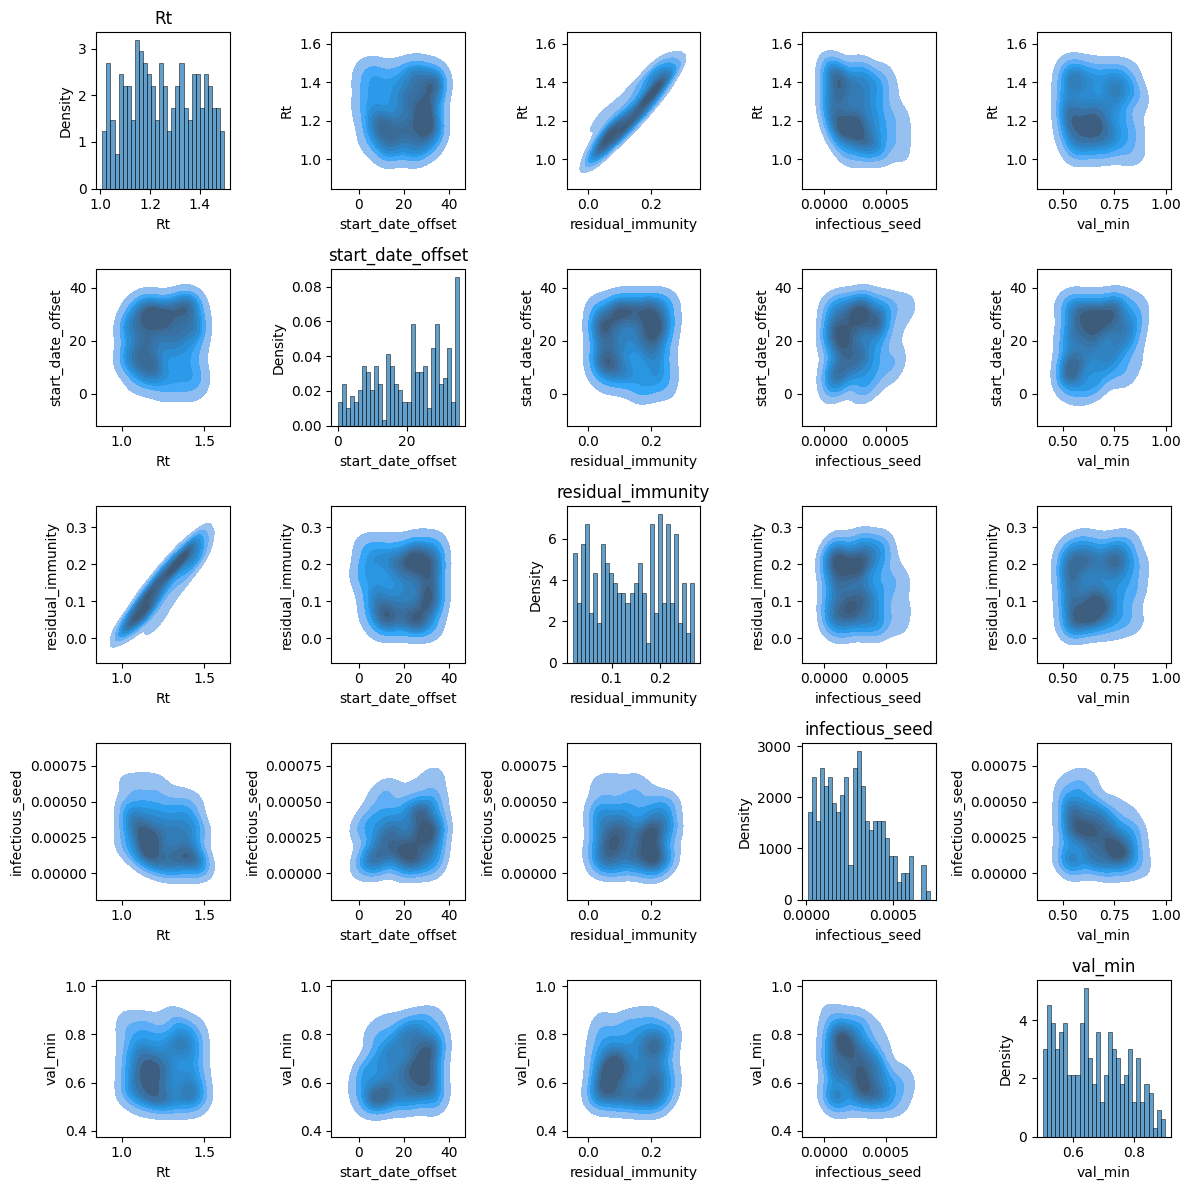

In [592]:
parameters_to_plot = ['Rt', 'start_date_offset', 'residual_immunity', 'infectious_seed', 'val_min']
df_posterior_top = results_top.get_posterior_distribution()
fig, axes = plot_posterior_matrix(
    df_posterior_top, 
    parameters_to_plot, 
    kind="kde",
    figsize=(12, 12)
)

/opt/anaconda3/envs/op_re/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


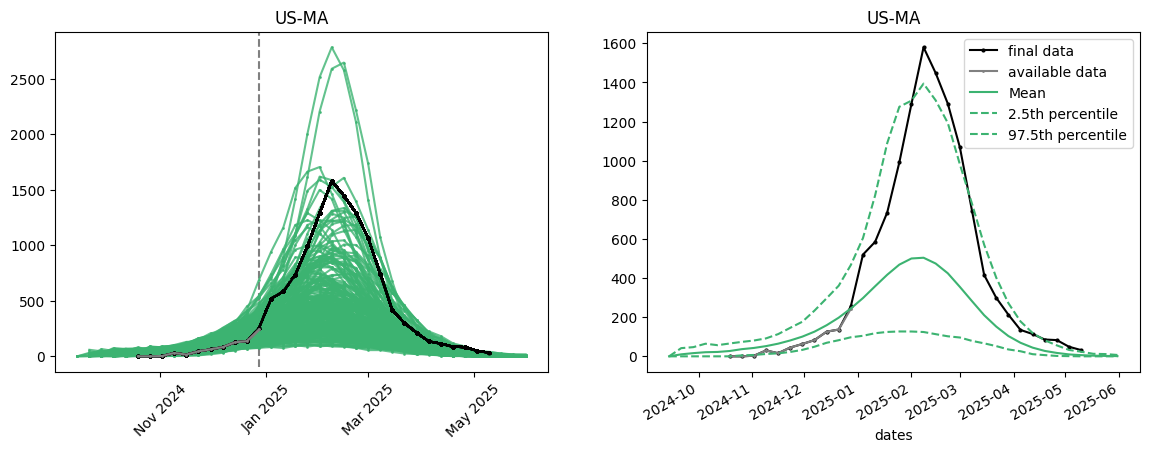

In [593]:
fig, ax = plt.subplots(1,2, figsize=(14, 5))
ax = ax.flatten()
for i, (model, results) in enumerate(zip([mdl_list[0]], [results_top])):
    posterior = results.get_posterior_distribution().reset_index()
    comp_stacked, trans_stacked = resimulate_with_posterior(model, posterior, parameters, all_scen, 'C_D')
    trans_stacked['total_hosp'] = trans_stacked["Home_severe_to_Hospitalized_total"] + trans_stacked["Home_severe_vax_to_Hospitalized_vax_total"]
    
    state_iso = convert_location_name_format(model.population.name, "ISO")
    hosp_data_state_final = hosp_data.query("geo_value == @state_iso")
    hosp_data_state_final = hosp_data_state_final[hosp_data_state_final['as_of'] == max(hosp_data_state_final['as_of'])]

    hosp_data_state = hosp_data[hosp_data['geo_value']==state_iso]
    hosp_data_state = hosp_data_state[hosp_data_state['as_of'] == '2025-01-01']

    ax[i].vlines(x=max(hosp_data_state.target_end_date), ymin=-100, ymax=100000, colors='gray', linestyles='dashed', label='Forecast date')
    for idx in trans_stacked['idx'].unique():
        df_plot = trans_stacked.query("idx == @idx")
        ax[i].plot(df_plot['dates'], df_plot['total_hosp'], color='mediumseagreen', alpha=0.8, marker='.', markersize=2)
        ax[i].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="data", markersize = 2)
        ax[i].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="data", markersize = 2)
    ax[i].set_title(state_iso)
    # ax[i].set_xlim([dt.date(2024, 9, 13), max(hosp_data_state.target_end_date)+dt.timedelta(days=4*7)])
    ymin = min(0, trans_stacked['total_hosp'].min(), hosp_data_state.value.min())
    ymax = max(hosp_data_state_final.value.max(), trans_stacked['total_hosp'].max())
    # add 5% padding
    padding = 0.05 * (ymax - ymin)
    ax[i].set_ylim(ymin - padding, ymax + padding)
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))   # show one tick per 2 months
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Jan 2021"
    ax[i].tick_params(axis='x', rotation=45)  # tilt labels for readability
    # ax[i].legend()

ax[1].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="final data", markersize = 2)
ax[1].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="available data", markersize = 2)
trans_stacked.groupby('dates')['total_hosp'].mean().plot(ax=ax[1], color='mediumseagreen', label='Mean')
trans_stacked.groupby('dates')['total_hosp'].quantile(0.025).plot(ax=ax[1], color='mediumseagreen', linestyle='--', label='2.5th percentile')
trans_stacked.groupby('dates')['total_hosp'].quantile(0.975).plot(ax=ax[1], color='mediumseagreen', linestyle='--', label='97.5th percentile')
ax[1].set_title(state_iso)
ax[1].legend()

In [ ]:
st_list = ['US-MA', 'US-TX', 'US-CA', 'US-VT', 'US-SD']
mdl_list = make_model_list(st_list, parameter_dict)

In [619]:
hosp_data

,as_of,geo_value,signal,source,time_type,time_value,issue,value,target_end_date
0,2024-11-20,US-AK,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-10-13,2024-11-17,1.0,2024-10-19
1,2024-11-20,US-AK,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-10-20,2024-11-17,3.0,2024-10-26
2,2024-11-20,US-AK,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-10-27,2024-11-17,7.0,2024-11-02
3,2024-11-20,US-AK,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-11-03,2024-11-17,5.0,2024-11-09
4,2024-11-20,US-AK,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-11-10,2024-11-17,7.0,2024-11-16
...,...,...,...,...,...,...,...,...,...
25816,2025-05-14,US-WY,confirmed_admissions_flu_ew_prelim,nhsn,week,2025-04-06,2025-05-11,1.0,2025-04-12
25817,2025-05-14,US-WY,confirmed_admissions_flu_ew_prelim,nhsn,week,2025-04-13,2025-05-11,3.0,2025-04-19
25818,2025-05-14,US-WY,confirmed_admissions_flu_ew_prelim,nhsn,week,2025-04-20,2025-05-11,6.0,2025-04-26
25819,2025-05-14,US-WY,confirmed_admissions_flu_ew_prelim,nhsn,week,2025-04-27,2025-05-11,1.0,2025-05-03


In [664]:
fixed_parameters = {
    "reference_date": dt.date(2024, 9, 13),
    "end_date": dt.date(2025, 5, 14),
    "resample_frequency": 'W-SAT',
    "val_max": 1.0,
}
priors = {
    'Rt': stats.uniform(1.0, 2.0-1.0), 
    'start_date_offset': stats.randint(low=0, high=36) ,
    'residual_immunity': stats.uniform(0.02, 0.35-0.02), 
    'infectious_seed': stats.uniform(0.00001, 0.00100-0.00001),
    'val_min': stats.uniform(0.5, 0.9-0.5),
}
results_top = calibrate(model = mdl_list[1], # epimodel with population added
                        date = '2025-05-14', # can be inherited from end_date
                        fixed_parameters = fixed_parameters, # fixed parameters for simulation e.g end_date, resample_frequency, reference_date
                        priors = priors, 
                        data = hosp_data, # data to calibrate on
                        target_transitions = target_transitions, # model output(s) to compare to data, if more than one, they will be summed
                        infectious_seed_compartments = ["Latent"], # compartments to seed with initial infectious individuals, if more than one, divided equally among them
                        residual_immunity_compartments = ["Initial_immune"], # compartments to place immune individuals, if more than one, divided equally among them. If not in model, it will be created
                        vaccine_probability_function = vaccine_probability_function, 
                        calc_beta = calc_beta, # function to calculate beta from R
                        vax_sched = all_scen, # vaccination schedule dataframe with all locations
                        scenario = 'C_D', # optional if vaccination schedule has multiple scenarios
                        strategy='top_fraction', 
                        top_fraction=0.05, Nsim=200)

Starting ABC top fraction selection with 200 simulations and top 5.0% selected
	Selected 10 particles (top 5.0%) with distance threshold 961.770432


In [666]:
from joblib import Parallel, delayed

def calibrate_single_model(model, date='2025-05-14', fixed_parameters=None, 
                          priors=None, data=None, target_transitions=None,
                          infectious_seed_compartments=None, 
                          residual_immunity_compartments=None,
                          vaccine_probability_function=None, calc_beta=None,
                          vax_sched=None, scenario=None, strategy=None,
                          top_fraction=None, Nsim=None):
    """Wrapper function to calibrate a single model"""
    
    return calibrate(
        model=model,
        date=date,
        fixed_parameters=fixed_parameters,
        priors=priors,
        data=data,
        target_transitions=target_transitions,
        infectious_seed_compartments=infectious_seed_compartments,
        residual_immunity_compartments=residual_immunity_compartments,
        vaccine_probability_function=vaccine_probability_function,
        calc_beta=calc_beta,
        vax_sched=vax_sched,
        scenario=scenario,
        strategy=strategy,
        top_fraction=top_fraction,
        Nsim=Nsim
    )

# Parallelize over all models in mdl_list
results_top_all = Parallel(n_jobs=5, verbose=1)(
    delayed(calibrate_single_model)(
        model=model,
        date='2025-05-14',
        fixed_parameters=fixed_parameters,
        priors=priors,
        data=hosp_data,
        target_transitions=target_transitions,
        infectious_seed_compartments=["Latent"],
        residual_immunity_compartments=["Initial_immune"],
        vaccine_probability_function=vaccine_probability_function,
        calc_beta=calc_beta,
        vax_sched=all_scen,
        scenario='C_D',
        strategy='top_fraction',
        top_fraction=0.05,
        Nsim=5000
    ) for model in mdl_list
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Starting ABC top fraction selection with 5000 simulations and top 5.0% selected
Starting ABC top fraction selection with 5000 simulations and top 5.0% selected
Starting ABC top fraction selection with 5000 simulations and top 5.0% selected
Starting ABC top fraction selection with 5000 simulations and top 5.0% selected
Starting ABC top fraction selection with 5000 simulations and top 5.0% selected
Simulation failed with parameters {'reference_date': datetime.date(2024, 9, 13), 'end_date': datetime.date(2025, 5, 14), 'resample_frequency': 'W-SAT', 'val_max': 1.0, 'Rt': np.float64(1.7383541937931675), 'start_date_offset': 23, 'residual_immunity': np.float64(0.3075366470102085), 'infectious_seed': np.float64(0.00013435521795231221), 'val_min': np.float64(0.5941643952107873)}: pvals < 0, pvals > 1 or pvals contains NaNs
Simulation failed with parameters {'reference_date': datetime.date(2024, 9, 13), 'end_date': datetime.date(2025, 5, 14), 'resample_frequency': 'W-SAT', 'val_max': 1.0, 'Rt':

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 55.7min remaining: 83.5min


	Selected 250 particles (top 5.0%) with distance threshold 470.500569
	Selected 250 particles (top 5.0%) with distance threshold 937.466310
	Selected 250 particles (top 5.0%) with distance threshold 884.728178


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 59.0min finished


In [596]:
results_smc = calibrate(model = mdl_list[0], 
                        date = '2025-01-01', 
                        fixed_parameters = fixed_parameters, 
                        priors = priors, 
                        data = hosp_data, 
                        target_transitions = target_transitions, 
                        infectious_seed_compartments = ["Latent"], 
                        residual_immunity_compartments = ["Initial_immune"],
                        vaccine_probability_function = vaccine_probability_function, 
                        calc_beta = calc_beta, 
                        vax_sched = all_scen, 
                        scenario = 'C_D', 
                        strategy='smc', 
                        num_particles=250, num_generations=5)

Starting ABC-SMC with 250 particles and 5 generations

Generation 1/5 (epsilon: inf)
	Accepted 250/250 (acceptance rate: 100.00%)
	Elapsed time: 00:00:54

Generation 2/5 (epsilon: 98.636367)
	Accepted 250/504 (acceptance rate: 49.60%)
	Elapsed time: 00:01:55

Generation 3/5 (epsilon: 89.027822)
	Accepted 250/813 (acceptance rate: 30.75%)
	Elapsed time: 00:02:56

Generation 4/5 (epsilon: 74.197811)
	Accepted 250/1719 (acceptance rate: 14.54%)
	Elapsed time: 00:06:21

Generation 5/5 (epsilon: 60.936989)
	Accepted 250/2863 (acceptance rate: 8.73%)
	Elapsed time: 00:10:15


In [662]:
hosp_data.as_of.unique()

<DatetimeArray>
['2024-11-20 00:00:00', '2024-11-27 00:00:00', '2024-12-04 00:00:00',
 '2024-12-11 00:00:00', '2024-12-18 00:00:00', '2024-12-25 00:00:00',
 '2025-01-01 00:00:00', '2025-01-08 00:00:00', '2025-01-15 00:00:00',
 '2025-01-22 00:00:00', '2025-01-29 00:00:00', '2025-02-05 00:00:00',
 '2025-02-12 00:00:00', '2025-02-19 00:00:00', '2025-02-26 00:00:00',
 '2025-03-05 00:00:00', '2025-03-12 00:00:00', '2025-03-19 00:00:00',
 '2025-03-26 00:00:00', '2025-04-02 00:00:00', '2025-04-09 00:00:00',
 '2025-04-16 00:00:00', '2025-04-23 00:00:00', '2025-04-30 00:00:00',
 '2025-05-07 00:00:00', '2025-05-14 00:00:00']
Length: 26, dtype: datetime64[ns]

In [682]:
from joblib import Parallel, delayed

def calibrate_single_model_smc(model, date='2025-05-14', fixed_parameters=None, 
                              priors=None, data=None, target_transitions=None,
                              infectious_seed_compartments=None, 
                              residual_immunity_compartments=None,
                              vaccine_probability_function=None, calc_beta=None,
                              vax_sched=None, scenario=None, strategy=None,
                              num_particles=None, num_generations=None):
    """Wrapper function to calibrate a single model using SMC"""
    return calibrate(
        model=model,
        date=date,
        fixed_parameters=fixed_parameters,
        priors=priors,
        data=data,
        target_transitions=target_transitions,
        infectious_seed_compartments=infectious_seed_compartments,
        residual_immunity_compartments=residual_immunity_compartments,
        vaccine_probability_function=vaccine_probability_function,
        calc_beta=calc_beta,
        vax_sched=vax_sched,
        scenario=scenario,
        strategy=strategy,
        num_particles=num_particles,
        num_generations=num_generations
    )

# Parallelize SMC calibration over all models in mdl_list
results_smc_all = Parallel(n_jobs=5, verbose=1)(
    delayed(calibrate_single_model_smc)(
        model=model,
        date='2025-05-14',
        fixed_parameters=fixed_parameters,
        priors=priors,
        data=hosp_data,
        target_transitions=target_transitions,
        infectious_seed_compartments=["Latent"],
        residual_immunity_compartments=["Initial_immune"],
        vaccine_probability_function=vaccine_probability_function,
        calc_beta=calc_beta,
        vax_sched=all_scen,
        scenario='C_D',
        strategy='smc',
        num_particles=250,
        num_generations=5
    ) for model in mdl_list
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Starting ABC-SMC with 250 particles and 5 generations

Generation 1/5 (epsilon: inf)
Starting ABC-SMC with 250 particles and 5 generations

Generation 1/5 (epsilon: inf)
Starting ABC-SMC with 250 particles and 5 generations

Generation 1/5 (epsilon: inf)
Starting ABC-SMC with 250 particles and 5 generations

Generation 1/5 (epsilon: inf)
Starting ABC-SMC with 250 particles and 5 generations

Generation 1/5 (epsilon: inf)
	Accepted 250/250 (acceptance rate: 100.00%)
	Elapsed time: 00:02:53

Generation 2/5 (epsilon: 65.552732)
	Accepted 250/250 (acceptance rate: 100.00%)
	Elapsed time: 00:03:01

Generation 2/5 (epsilon: 110.260462)
	Accepted 250/250 (acceptance rate: 100.00%)
	Elapsed time: 00:03:11

Generation 2/5 (epsilon: 638.761974)
	Accepted 250/250 (acceptance rate: 100.00%)
	Elapsed time: 00:03:18

Generation 2/5 (epsilon: 3133.989407)
	Accepted 250/250 (acceptance rate: 100.00%)
	Elapsed time: 00:03:19

Generation 2/5 (epsilon: 3663.164019)
Simulation failed with parameters {'ref

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 59.0min remaining: 88.5min


	Accepted 250/2440 (acceptance rate: 10.25%)
	Elapsed time: 00:23:25
	Accepted 250/2580 (acceptance rate: 9.69%)
	Elapsed time: 00:26:15
Simulation failed with parameters {'reference_date': datetime.date(2024, 9, 13), 'end_date': datetime.date(2025, 5, 14), 'resample_frequency': 'W-SAT', 'val_max': 1.0, 'Rt': 1.78256595003699, 'start_date_offset': np.int64(28), 'residual_immunity': 0.3269995043417321, 'infectious_seed': 9.066604738705225e-05, 'val_min': 0.7515251599102886}: pvals < 0, pvals > 1 or pvals contains NaNs
	Accepted 250/2757 (acceptance rate: 9.07%)
	Elapsed time: 00:25:08


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 64.4min finished


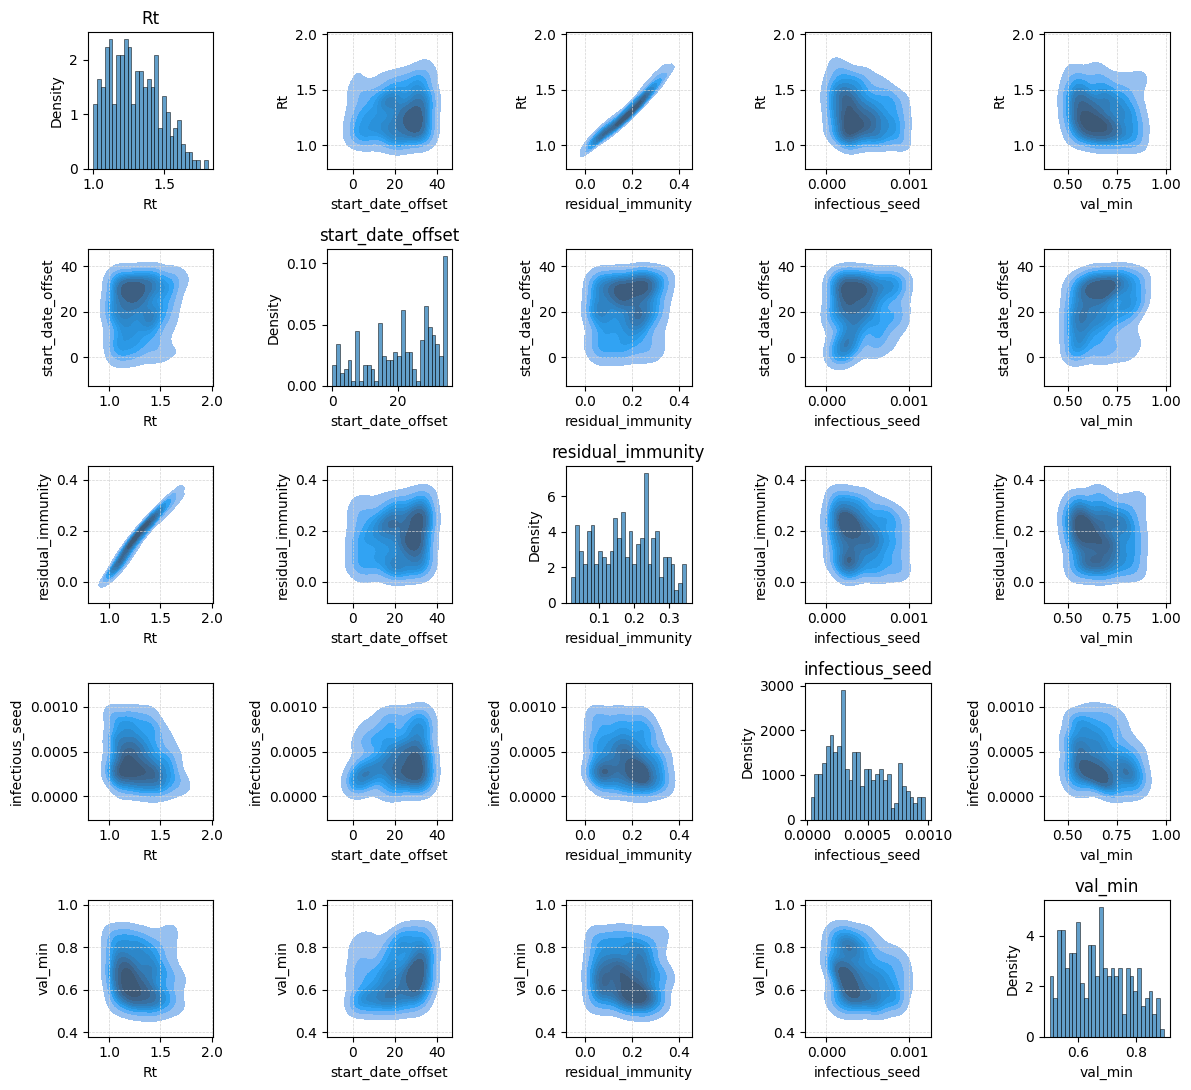

In [683]:
parameters_to_plot = ['Rt', 'start_date_offset', 'residual_immunity', 'infectious_seed', 'val_min']
df_posterior_smc = results_smc_all[1].get_posterior_distribution()
fig, axes = plot_posterior_matrix(
    df_posterior_smc, 
    parameters_to_plot, 
    kind="kde",
    figsize=(12, 11)
)
plt.savefig('posterior_matrix_smc.pdf', dpi=300)

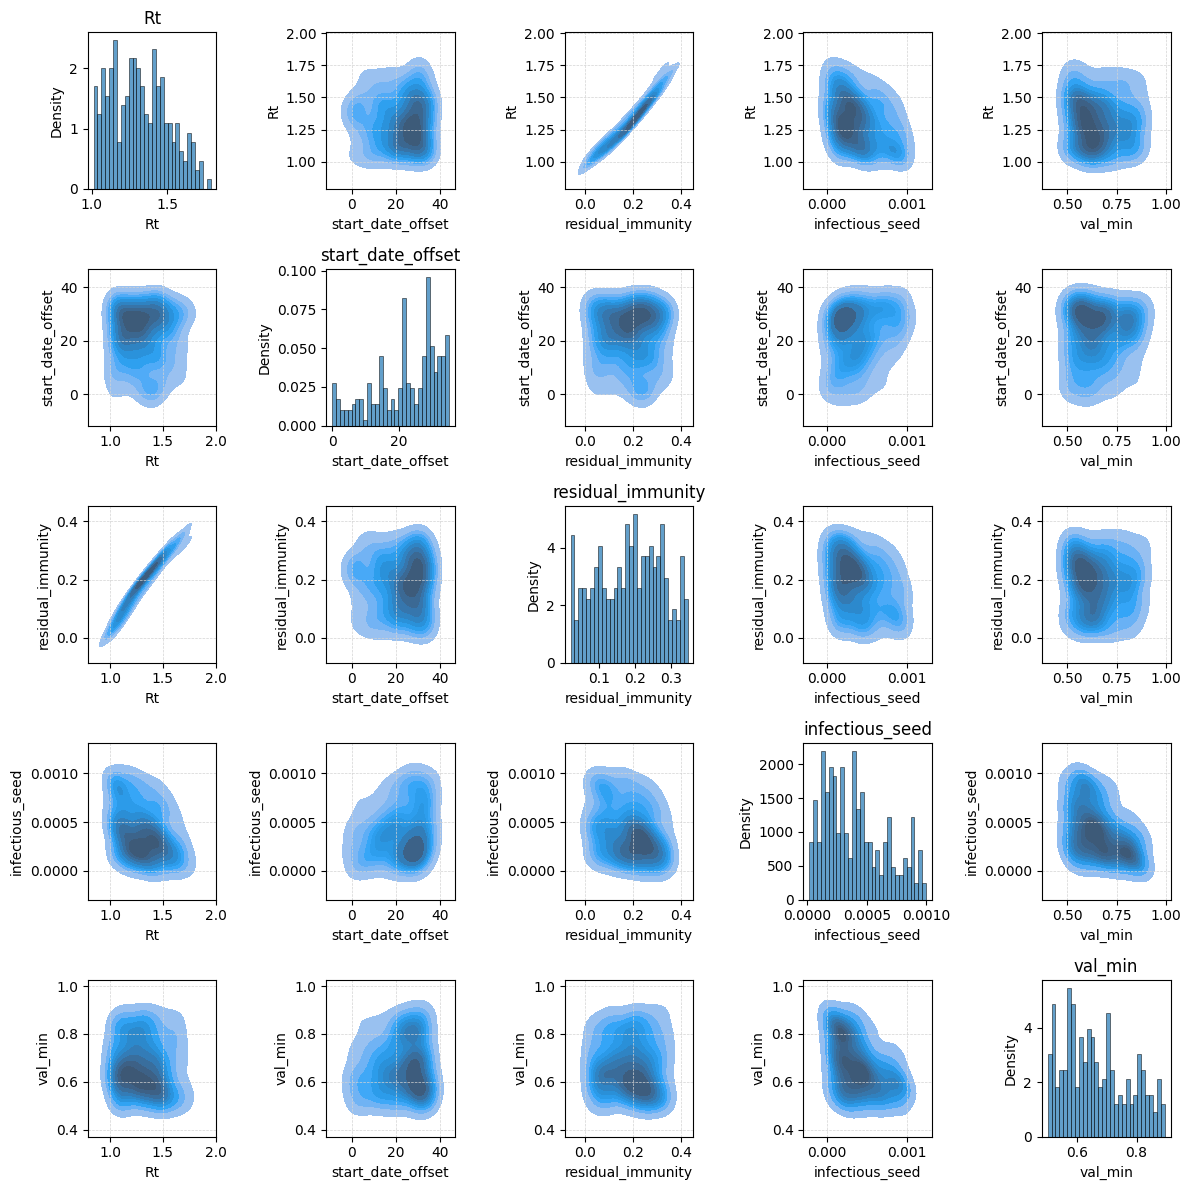

In [673]:
parameters_to_plot = ['Rt', 'start_date_offset', 'residual_immunity', 'infectious_seed', 'val_min']
df_posterior_top = results_top_all[1].get_posterior_distribution()
fig, axes = plot_posterior_matrix(
    df_posterior_top, 
    parameters_to_plot, 
    kind="kde",
    figsize=(12, 12)
)

/opt/anaconda3/envs/op_re/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


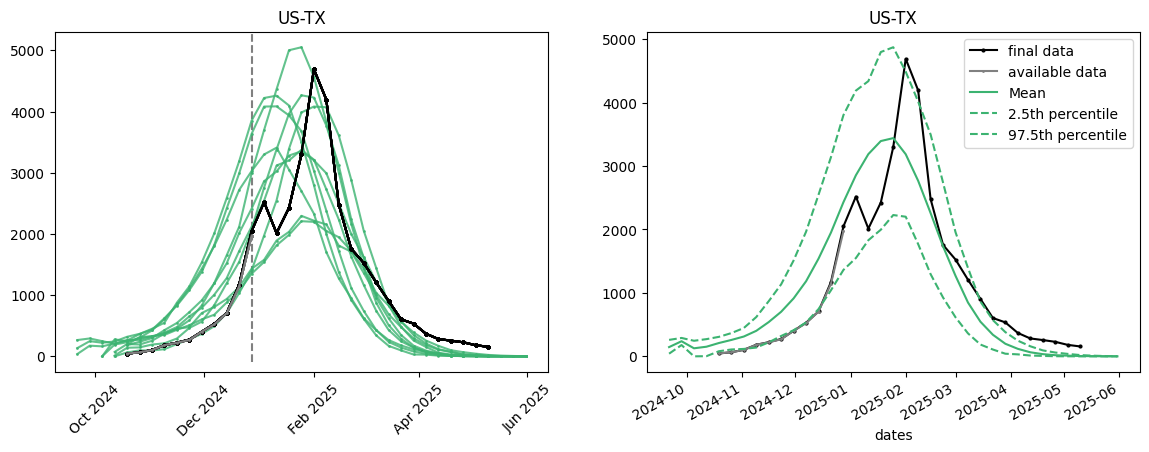

In [665]:
fig, ax = plt.subplots(1,2, figsize=(14, 5))
ax = ax.flatten()
for i, (model, results) in enumerate(zip([mdl_list[1]], [results_top])):
    posterior = results.get_posterior_distribution().reset_index()
    comp_stacked, trans_stacked = resimulate_with_posterior(model, posterior, parameters, all_scen, 'C_D')
    trans_stacked['total_hosp'] = trans_stacked["Home_severe_to_Hospitalized_total"] + trans_stacked["Home_severe_vax_to_Hospitalized_vax_total"]
    
    state_iso = convert_location_name_format(model.population.name, "ISO")
    hosp_data_state_final = hosp_data.query("geo_value == @state_iso")
    hosp_data_state_final = hosp_data_state_final[hosp_data_state_final['as_of'] == max(hosp_data_state_final['as_of'])]

    hosp_data_state = hosp_data[hosp_data['geo_value']==state_iso]
    hosp_data_state = hosp_data_state[hosp_data_state['as_of'] == '2025-01-01']

    ax[i].vlines(x=max(hosp_data_state.target_end_date), ymin=-100, ymax=100000, colors='gray', linestyles='dashed', label='Forecast date')
    for idx in trans_stacked['idx'].unique():
        df_plot = trans_stacked.query("idx == @idx")
        ax[i].plot(df_plot['dates'], df_plot['total_hosp'], color='mediumseagreen', alpha=0.8, marker='.', markersize=2)
        ax[i].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="data", markersize = 2)
        ax[i].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="data", markersize = 2)
    ax[i].set_title(state_iso)
    # ax[i].set_xlim([dt.date(2024, 9, 13), max(hosp_data_state.target_end_date)+dt.timedelta(days=4*7)])
    ymin = min(0, trans_stacked['total_hosp'].min(), hosp_data_state.value.min())
    ymax = max(hosp_data_state_final.value.max(), trans_stacked['total_hosp'].max())
    # add 5% padding
    padding = 0.05 * (ymax - ymin)
    ax[i].set_ylim(ymin - padding, ymax + padding)
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))   # show one tick per 2 months
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Jan 2021"
    ax[i].tick_params(axis='x', rotation=45)  # tilt labels for readability
    # ax[i].legend()

ax[1].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="final data", markersize = 2)
ax[1].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="available data", markersize = 2)
trans_stacked.groupby('dates')['total_hosp'].mean().plot(ax=ax[1], color='mediumseagreen', label='Mean')
trans_stacked.groupby('dates')['total_hosp'].quantile(0.025).plot(ax=ax[1], color='mediumseagreen', linestyle='--', label='2.5th percentile')
trans_stacked.groupby('dates')['total_hosp'].quantile(0.975).plot(ax=ax[1], color='mediumseagreen', linestyle='--', label='97.5th percentile')
ax[1].set_title(state_iso)
ax[1].legend()

In [636]:
results_top_all[0].get_posterior_distribution()

,Rt,start_date_offset,residual_immunity,infectious_seed,val_min
1,1.390946,9,0.286662,0.000066,0.841798
38,2.004299,26,0.345700,0.000162,0.513227
50,1.165626,27,0.190275,0.000273,0.586027
76,1.412545,21,0.326341,0.000093,0.673352
86,1.036620,6,0.290433,0.000196,0.715829
88,1.422435,30,0.335657,0.000114,0.733753
113,1.018788,30,0.341462,0.000210,0.721595
119,1.068038,5,0.253899,0.000088,0.613981
175,1.121653,3,0.115727,0.000189,0.534838
236,1.226815,19,0.243289,0.000081,0.762414


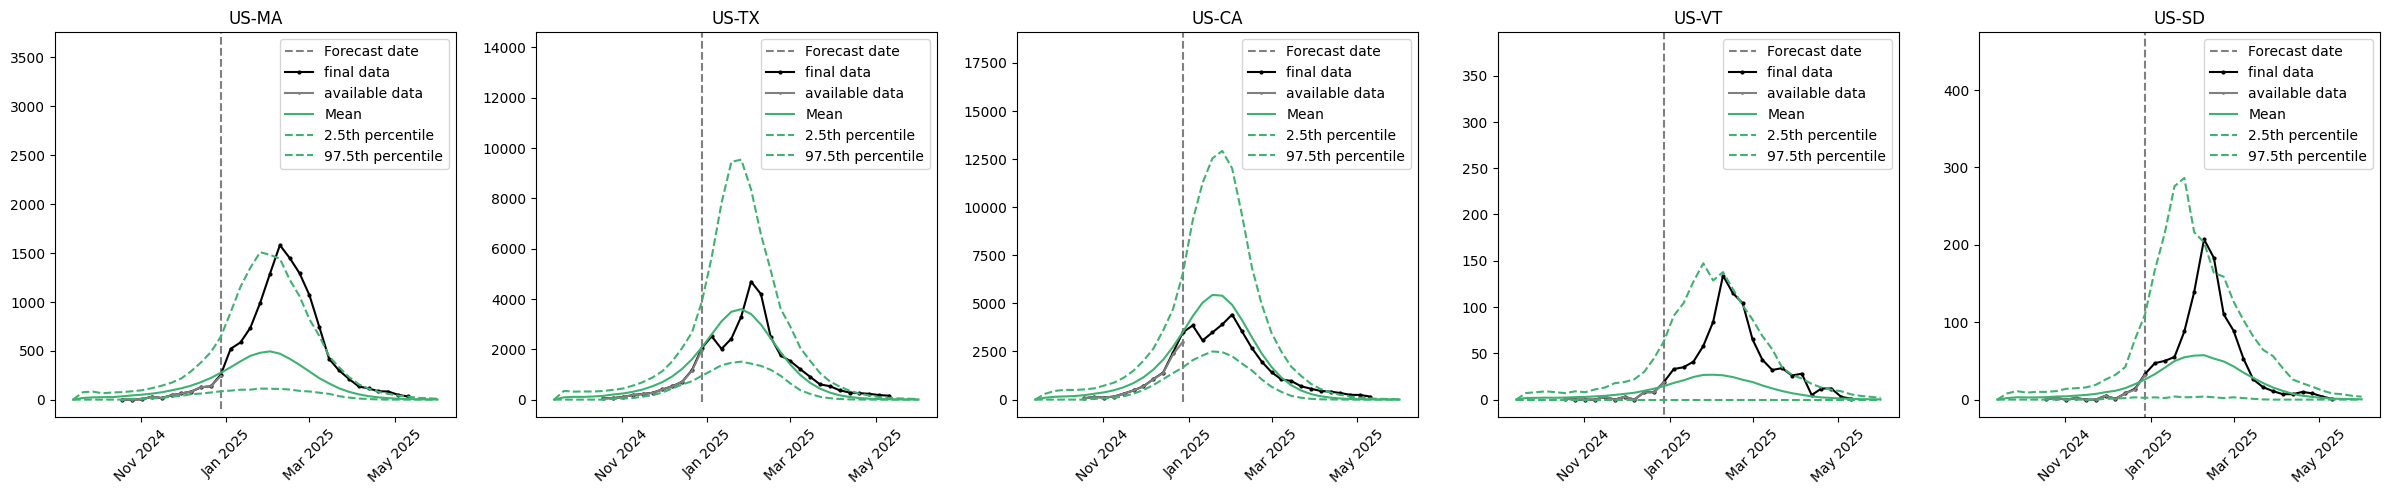

In [653]:
fig, ax = plt.subplots(1,5, figsize=(30, 5))
ax = ax.flatten()
for i, (model, results) in enumerate(zip(mdl_list, results_top_all)):
    posterior = results.get_posterior_distribution().reset_index()
    comp_stacked, trans_stacked = resimulate_with_posterior(model, posterior, parameters, all_scen, 'C_D')
    trans_stacked['total_hosp'] = trans_stacked["Home_severe_to_Hospitalized_total"] + trans_stacked["Home_severe_vax_to_Hospitalized_vax_total"]
    
    state_iso = convert_location_name_format(model.population.name, "ISO")
    hosp_data_state_final = hosp_data.query("geo_value == @state_iso")
    hosp_data_state_final = hosp_data_state_final[hosp_data_state_final['as_of'] == max(hosp_data_state_final['as_of'])]

    hosp_data_state = hosp_data[hosp_data['geo_value']==state_iso]
    hosp_data_state = hosp_data_state[hosp_data_state['as_of'] == '2025-01-01']

    ax[i].vlines(x=max(hosp_data_state.target_end_date), ymin=-100, ymax=100000, colors='gray', linestyles='dashed', label='Forecast date')
    # for idx in trans_stacked['idx'].unique():
    #     df_plot = trans_stacked.query("idx == @idx")
    #     ax[i].plot(df_plot['dates'], df_plot['total_hosp'], color='mediumseagreen', alpha=0.8, marker='.', markersize=2)
    #     ax[i].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="data", markersize = 2)
    #     ax[i].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="data", markersize = 2)
    # ax[i].set_title(state_iso)
    ax[i].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="final data", markersize = 2)
    ax[i].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="available data", markersize = 2)
    
    mean_series = trans_stacked.groupby('dates')['total_hosp'].mean()
    ax[i].plot(mean_series.index, mean_series.values, color="mediumseagreen", label="Mean")
    q_lower = trans_stacked.groupby('dates')['total_hosp'].quantile(0.025)
    ax[i].plot(q_lower.index, q_lower.values, color="mediumseagreen", linestyle='--', label="2.5th percentile")
    q_upper = trans_stacked.groupby('dates')['total_hosp'].quantile(0.975)
    ax[i].plot(q_upper.index, q_upper.values, color='mediumseagreen', linestyle='--', label='97.5th percentile')
    
    ax[i].set_title(state_iso)
    ax[i].legend()
    # ax[i].set_xlim([dt.date(2024, 9, 13), max(hosp_data_state.target_end_date)+dt.timedelta(days=4*7)])
    ymin = min(0, trans_stacked['total_hosp'].min(), hosp_data_state.value.min())
    ymax = max(hosp_data_state_final.value.max(), trans_stacked['total_hosp'].max())
    # add 5% padding
    padding = 0.05 * (ymax - ymin)
    ax[i].set_ylim(ymin - padding, ymax + padding)
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))   # show one tick per 2 months
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Jan 2021"
    ax[i].tick_params(axis='x', rotation=45)  # tilt labels for readability
    # ax[i].legend()



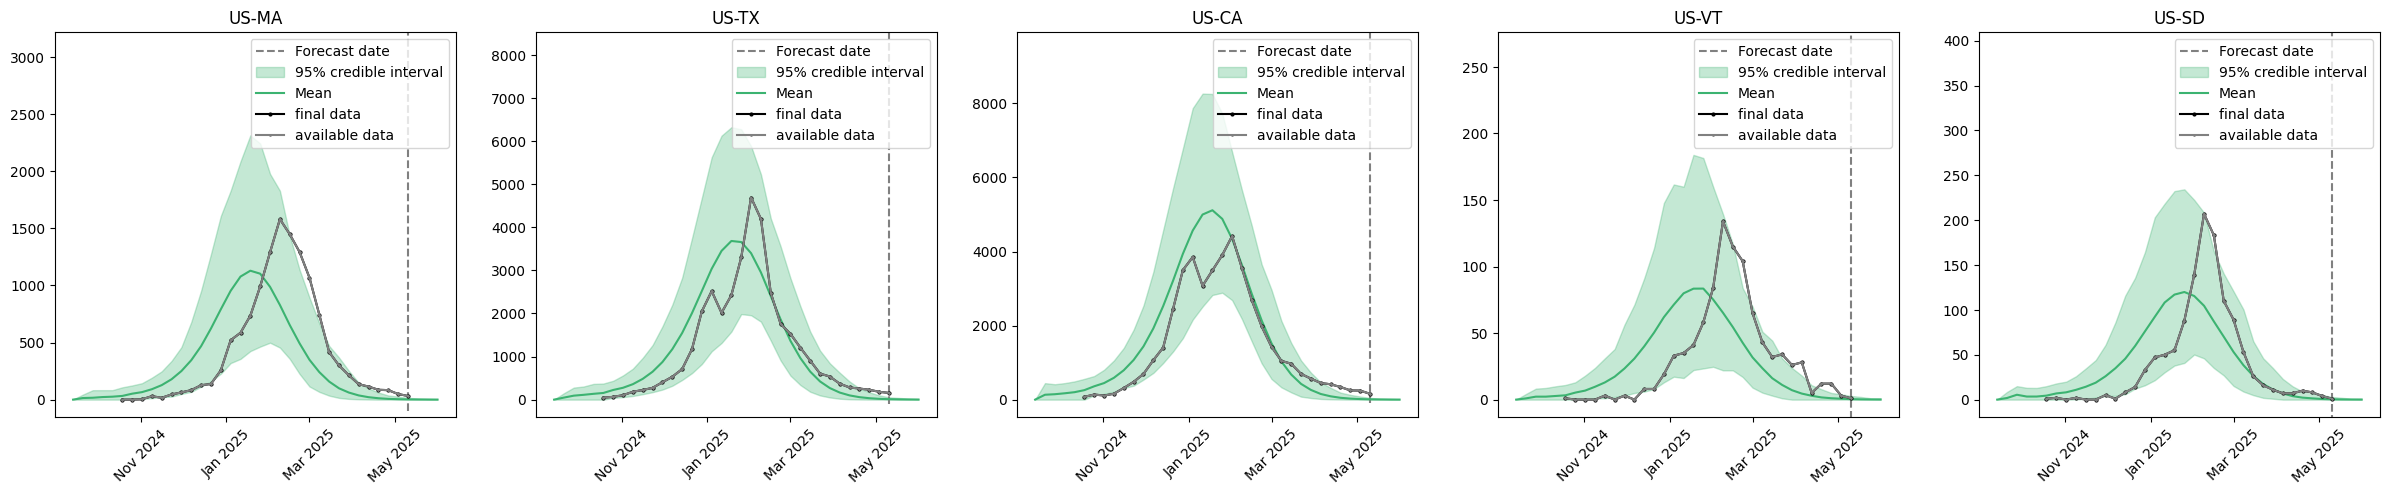

In [684]:
fig, ax = plt.subplots(1,5, figsize=(30, 5))
ax = ax.flatten()
for i, (model, results) in enumerate(zip(mdl_list, results_smc_all)):
    posterior = results.get_posterior_distribution().reset_index()
    comp_stacked, trans_stacked = resimulate_with_posterior(model, posterior, parameters, all_scen, 'C_D')
    trans_stacked['total_hosp'] = trans_stacked["Home_severe_to_Hospitalized_total"] + trans_stacked["Home_severe_vax_to_Hospitalized_vax_total"]
    
    state_iso = convert_location_name_format(model.population.name, "ISO")
    hosp_data_state_final = hosp_data.query("geo_value == @state_iso")
    hosp_data_state_final = hosp_data_state_final[hosp_data_state_final['as_of'] == max(hosp_data_state_final['as_of'])]

    hosp_data_state = hosp_data[hosp_data['geo_value']==state_iso]
    hosp_data_state = hosp_data_state[hosp_data_state['as_of'] == '2025-05-14']

    ax[i].vlines(x=max(hosp_data_state.target_end_date), ymin=-100, ymax=100000, colors='gray', linestyles='dashed', label='Forecast date')
    # for idx in trans_stacked['idx'].unique():
    #     df_plot = trans_stacked.query("idx == @idx")
    #     ax[i].plot(df_plot['dates'], df_plot['total_hosp'], color='mediumseagreen', alpha=0.8, marker='.', markersize=2)
    #     ax[i].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="data", markersize = 2)
    #     ax[i].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="data", markersize = 2)
    # ax[i].set_title(state_iso)
    
    q_lower = trans_stacked.groupby('dates')['total_hosp'].quantile(0.025)
    # ax[i].plot(q_lower.index, q_lower.values, color="mediumseagreen", linestyle='--', label="2.5th percentile")
    q_upper = trans_stacked.groupby('dates')['total_hosp'].quantile(0.975)
    # ax[i].plot(q_upper.index, q_upper.values, color='mediumseagreen', linestyle='--', label='97.5th percentile')
    ax[i].fill_between(q_lower.index, q_lower.values, q_upper.values, color='mediumseagreen', alpha=0.3, label='95% credible interval')
    mean_series = trans_stacked.groupby('dates')['total_hosp'].mean()
    ax[i].plot(mean_series.index, mean_series.values, color="mediumseagreen", label="Mean")

    ax[i].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="final data", markersize = 2)
    ax[i].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="available data", markersize = 2)

    ax[i].set_title(state_iso)
    ax[i].legend()
    # ax[i].set_xlim([dt.date(2024, 9, 13), max(hosp_data_state.target_end_date)+dt.timedelta(days=4*7)])
    ymin = min(0, trans_stacked['total_hosp'].min(), hosp_data_state.value.min())
    ymax = max(hosp_data_state_final.value.max(), trans_stacked['total_hosp'].max())
    # add 5% padding
    padding = 0.05 * (ymax - ymin)
    ax[i].set_ylim(ymin - padding, ymax + padding)
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))   # show one tick per 2 months
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Jan 2021"
    ax[i].tick_params(axis='x', rotation=45)  # tilt labels for readability
    # ax[i].legend()
    plt.savefig('smc_time_series.pdf', dpi=300, bbox_inches='tight')


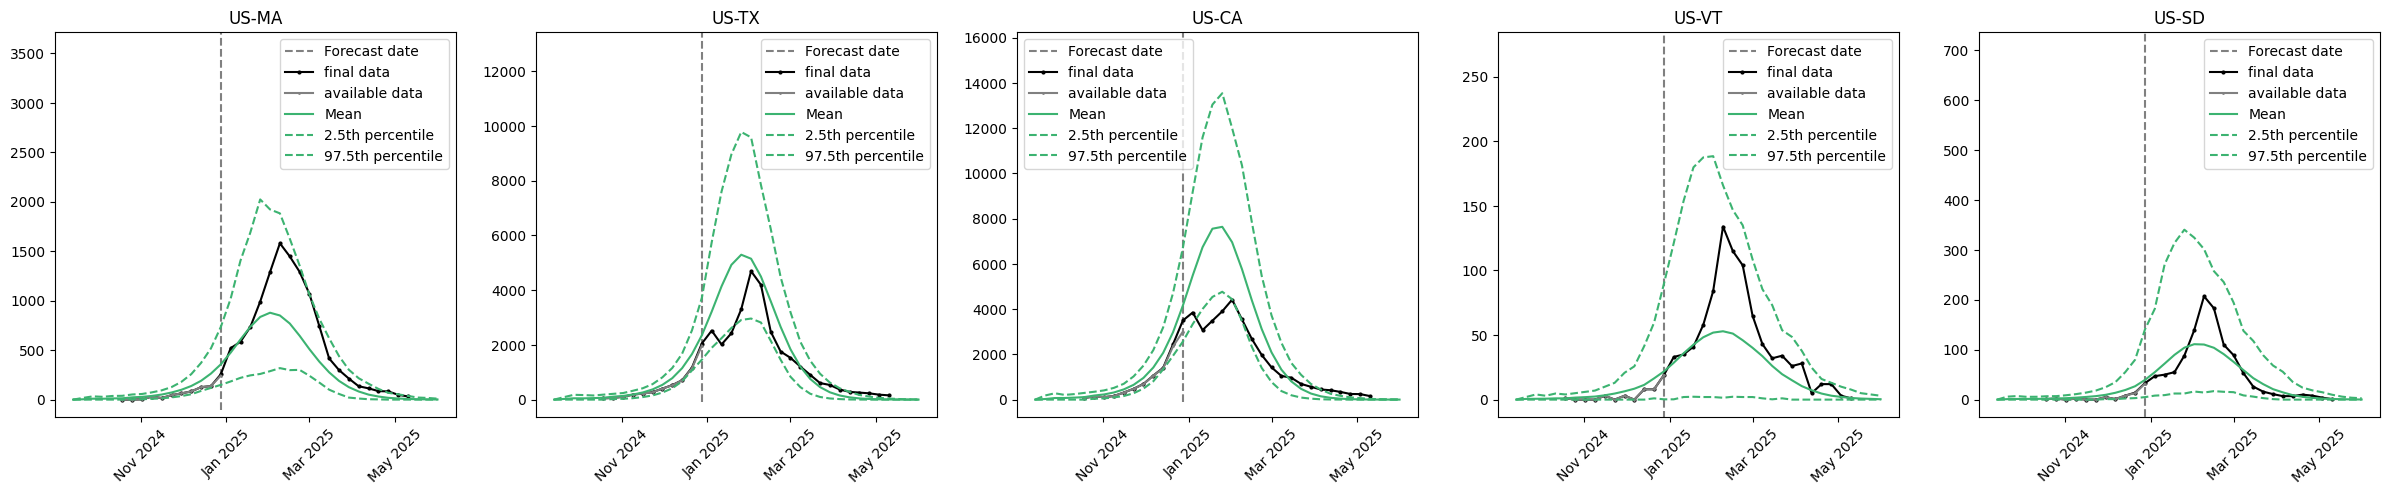

In [660]:
fig, ax = plt.subplots(1,5, figsize=(30, 5))
ax = ax.flatten()
for i, (model, results) in enumerate(zip(mdl_list, results_smc_all)):
    posterior = results.get_posterior_distribution().reset_index()
    comp_stacked, trans_stacked = resimulate_with_posterior(model, posterior, parameters, all_scen, 'C_D')
    trans_stacked['total_hosp'] = trans_stacked["Home_severe_to_Hospitalized_total"] + trans_stacked["Home_severe_vax_to_Hospitalized_vax_total"]
    
    state_iso = convert_location_name_format(model.population.name, "ISO")
    hosp_data_state_final = hosp_data.query("geo_value == @state_iso")
    hosp_data_state_final = hosp_data_state_final[hosp_data_state_final['as_of'] == max(hosp_data_state_final['as_of'])]

    hosp_data_state = hosp_data[hosp_data['geo_value']==state_iso]
    hosp_data_state = hosp_data_state[hosp_data_state['as_of'] == '2025-01-01']

    ax[i].vlines(x=max(hosp_data_state.target_end_date), ymin=-100, ymax=100000, colors='gray', linestyles='dashed', label='Forecast date')
    # for idx in trans_stacked['idx'].unique():
    #     df_plot = trans_stacked.query("idx == @idx")
    #     ax[i].plot(df_plot['dates'], df_plot['total_hosp'], color='mediumseagreen', alpha=0.8, marker='.', markersize=2)
    #     ax[i].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="data", markersize = 2)
    #     ax[i].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="data", markersize = 2)
    # ax[i].set_title(state_iso)
    ax[i].plot(hosp_data_state_final.target_end_date, hosp_data_state_final.value, marker='o', linestyle='-', color='black', label="final data", markersize = 2)
    ax[i].plot(hosp_data_state.target_end_date, hosp_data_state.value, marker='.', linestyle='-', color='grey', label="available data", markersize = 2)
    
    mean_series = trans_stacked.groupby('dates')['total_hosp'].mean()
    ax[i].plot(mean_series.index, mean_series.values, color="mediumseagreen", label="Mean")
    q_lower = trans_stacked.groupby('dates')['total_hosp'].quantile(0.025)
    ax[i].plot(q_lower.index, q_lower.values, color="mediumseagreen", linestyle='--', label="2.5th percentile")
    q_upper = trans_stacked.groupby('dates')['total_hosp'].quantile(0.975)
    ax[i].plot(q_upper.index, q_upper.values, color='mediumseagreen', linestyle='--', label='97.5th percentile')
    
    ax[i].set_title(state_iso)
    ax[i].legend()
    # ax[i].set_xlim([dt.date(2024, 9, 13), max(hosp_data_state.target_end_date)+dt.timedelta(days=4*7)])
    ymin = min(0, trans_stacked['total_hosp'].min(), hosp_data_state.value.min())
    ymax = max(hosp_data_state_final.value.max(), trans_stacked['total_hosp'].max())
    # add 5% padding
    padding = 0.05 * (ymax - ymin)
    ax[i].set_ylim(ymin - padding, ymax + padding)
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))   # show one tick per 2 months
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Jan 2021"
    ax[i].tick_params(axis='x', rotation=45)  # tilt labels for readability
    # ax[i].legend()

